In [1]:
from platform import python_version
print(python_version())

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from DataPreparation.dataset_preparation import get_SVHN_dataset
from sklearn.model_selection import train_test_split
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

# A. Load the Dataset
Set the data directory to the path where the following files exist: train_32x32.mat, test_32x32.mat <br>

In [3]:
data_dir = 'Dataset/SVHN/'
validation_split = 0.2
seed = 6135

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test, X_train_moments = get_SVHN_dataset(data_dir, validation_split,
                                                                                   seed, zero_mean=True, normalize=True)
scale = lambda img: X_train_moments[0] + (img * X_train_moments[1])
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape: ', X_test.shape)
print('y_val shape: ', y_test.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

Generating numpy dataset from existing .mat files in Dataset/SVHN/
X_train shape:  (58606, 3, 32, 32)
y_train shape:  (58606,)
X_val shape:  (26032, 3, 32, 32)
y_val shape:  (26032,)
X_test shape:  (26032, 3, 32, 32)
y_test shape:  (26032,)


### Visualization sanity check

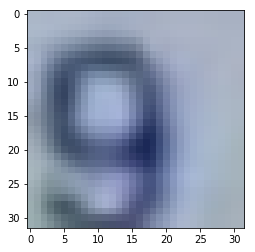

In [5]:
plt.imshow(np.transpose(scale(X_test[250]), (1, 2, 0)).astype('uint8'))
plt.show()

In [6]:
batch_size = 256
X_train_ = TensorDataset(torch.from_numpy(X_train))
loader_train  = DataLoader(X_train_, batch_size=batch_size, shuffle=True)

X_val_ = TensorDataset(torch.from_numpy(X_val))
loader_val = DataLoader(X_val_, batch_size=batch_size, shuffle=False)

X_test_ = TensorDataset(torch.from_numpy(X_test))
loader_test = DataLoader(X_test_, batch_size=batch_size, shuffle=False)

# B. Train the Model

### Select device

In [7]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Using device=GPU') if use_cuda else print('Using device=CPU')

Using device=GPU


### VAE

In [8]:
from models.vae import VAE
num_latent = 100
model = VAE(num_latent).to(device)

In [9]:
# Hyperparameters
learning_rate = 3e-4
num_epochs = 100

In [10]:
from utils.train_eval_utils import train_model
print('~~~ Training with GPU ~~~') if use_cuda else print('~~~ Training with CPU ~~~\n')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Model has %.2fM trainable parameters.\n' % (num_params/1e6))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_history = train_model(model, optimizer, loader_train,
                            loader_val, num_epochs,
                            device)

~~~ Training with GPU ~~~
Model has 4.11M trainable parameters.

Epoch 1:
Train: elbo -191.6142, likelihood -174.0716, KL 17.5426
Validation: elbo -127.4702, likelihood -104.2851, KL 23.1852
-----------
Epoch 2:
Train: elbo -117.7713, likelihood -92.6014, KL 25.1699
Validation: elbo -105.3100, likelihood -81.3271, KL 23.9828
-----------
Epoch 3:
Train: elbo -97.7351, likelihood -73.3038, KL 24.4313
Validation: elbo -92.3496, likelihood -67.3608, KL 24.9888
-----------
Epoch 4:
Train: elbo -89.8553, likelihood -65.1010, KL 24.7543
Validation: elbo -86.5992, likelihood -61.3045, KL 25.2946
-----------
Epoch 5:
Train: elbo -86.2445, likelihood -60.7263, KL 25.5183
Validation: elbo -83.7023, likelihood -57.8656, KL 25.8367
-----------
Epoch 6:
Train: elbo -84.2746, likelihood -58.2822, KL 25.9923
Validation: elbo -82.4361, likelihood -56.2486, KL 26.1876
-----------
Epoch 7:
Train: elbo -83.1018, likelihood -56.7682, KL 26.3336
Validation: elbo -81.2247, likelihood -54.6232, KL 26.6015
---

Epoch 62:
Train: elbo -70.1926, likelihood -41.6367, KL 28.5559
Validation: elbo -71.8162, likelihood -43.0259, KL 28.7902
-----------
Epoch 63:
Train: elbo -69.9021, likelihood -41.3274, KL 28.5747
Validation: elbo -71.4961, likelihood -42.6659, KL 28.8302
-----------
Epoch 64:
Train: elbo -69.9174, likelihood -41.3325, KL 28.5849
Validation: elbo -71.9912, likelihood -43.2970, KL 28.6942
-----------
Epoch 65:
Train: elbo -70.0177, likelihood -41.4443, KL 28.5733
Validation: elbo -72.2413, likelihood -43.2053, KL 29.0360
-----------
Epoch 66:
Train: elbo -69.6502, likelihood -41.0649, KL 28.5853
Validation: elbo -71.6422, likelihood -42.7430, KL 28.8992
-----------
Epoch 67:
Train: elbo -70.0164, likelihood -41.4283, KL 28.5881
Validation: elbo -71.6759, likelihood -43.3089, KL 28.3670
-----------
Epoch 68:
Train: elbo -69.7750, likelihood -41.2070, KL 28.5680
Validation: elbo -71.7667, likelihood -42.8731, KL 28.8936
-----------
Epoch 69:
Train: elbo -69.4793, likelihood -40.8471, KL

In [11]:
PATH = 'vae100.pt'
torch.save(model, PATH)

### GAN

In [78]:
from models.gan import Generator, Discriminator
num_latent = 100
generator = Generator(num_latent).to(device)
discriminator = Discriminator().to(device)

In [79]:
# Hyperparameters
learning_rate = 1e-4
b1 = 0.5
b2 = 0.999
num_iterations = 10000
d_iterations = 5

~~~ Training with GPU ~~~
Generator has 3.45M trainable parameters.
Discriminator has 2.64M trainable parameters.

Iteration: 0, Loss generator: -3.1119604110717773, Loss discriminator 3.4508938789367676
Iteration: 1, Loss generator: -8.708955764770508, Loss discriminator 10.463284492492676
Iteration: 2, Loss generator: -12.009038925170898, Loss discriminator 17.201885223388672
Iteration: 3, Loss generator: -14.139894485473633, Loss discriminator 22.455707550048828
Iteration: 4, Loss generator: -15.832989692687988, Loss discriminator 26.764667510986328
Iteration: 5, Loss generator: -17.383705139160156, Loss discriminator 30.677217483520508
Iteration: 6, Loss generator: -18.834922790527344, Loss discriminator 34.086082458496094
Iteration: 7, Loss generator: -20.254695892333984, Loss discriminator 37.14043426513672
Iteration: 8, Loss generator: -21.638259887695312, Loss discriminator 40.207244873046875
Iteration: 9, Loss generator: -23.00192642211914, Loss discriminator 43.25095367431640

Iteration: 92, Loss generator: -131.64175415039062, Loss discriminator 271.4005126953125
Iteration: 93, Loss generator: -138.97445678710938, Loss discriminator 281.71929931640625
Iteration: 94, Loss generator: -141.782470703125, Loss discriminator 288.4981689453125
Iteration: 95, Loss generator: -144.3140869140625, Loss discriminator 291.5050048828125
Iteration: 96, Loss generator: -146.68814086914062, Loss discriminator 299.77056884765625
Iteration: 97, Loss generator: -149.8865966796875, Loss discriminator 304.7447509765625
Iteration: 98, Loss generator: -149.25949096679688, Loss discriminator 300.16278076171875
Iteration: 99, Loss generator: -150.98968505859375, Loss discriminator 309.802490234375
Iteration: 100, Loss generator: -154.44479370117188, Loss discriminator 311.1671447753906
Iteration: 101, Loss generator: -158.30438232421875, Loss discriminator 320.4522705078125
Iteration: 102, Loss generator: -158.57870483398438, Loss discriminator 320.250732421875
Iteration: 103, Loss 

Iteration: 185, Loss generator: -348.3939208984375, Loss discriminator 693.938232421875
Iteration: 186, Loss generator: -355.44952392578125, Loss discriminator 715.8129272460938
Iteration: 187, Loss generator: -357.4969482421875, Loss discriminator 721.918212890625
Iteration: 188, Loss generator: -359.3505554199219, Loss discriminator 724.4071044921875
Iteration: 189, Loss generator: -362.8630065917969, Loss discriminator 728.21044921875
Iteration: 190, Loss generator: -363.9791564941406, Loss discriminator 736.918212890625
Iteration: 191, Loss generator: -368.5052490234375, Loss discriminator 743.1365966796875
Iteration: 192, Loss generator: -361.3687438964844, Loss discriminator 739.619873046875
Iteration: 193, Loss generator: -367.23492431640625, Loss discriminator 734.540771484375
Iteration: 194, Loss generator: -373.6109619140625, Loss discriminator 752.510986328125
Iteration: 195, Loss generator: -368.4408874511719, Loss discriminator 740.646240234375
Iteration: 196, Loss generat

Iteration: 278, Loss generator: -100.97892761230469, Loss discriminator 485.21826171875
Iteration: 279, Loss generator: -141.84388732910156, Loss discriminator 523.2493896484375
Iteration: 280, Loss generator: -206.77713012695312, Loss discriminator 513.5444946289062
Iteration: 281, Loss generator: 209.24795532226562, Loss discriminator 601.8458251953125
Iteration: 282, Loss generator: 194.76007080078125, Loss discriminator 173.1036376953125
Iteration: 283, Loss generator: 102.52220153808594, Loss discriminator 302.0369873046875
Iteration: 284, Loss generator: 26.462974548339844, Loss discriminator 336.66607666015625
Iteration: 285, Loss generator: 59.561771392822266, Loss discriminator 377.369384765625
Iteration: 286, Loss generator: 92.3680419921875, Loss discriminator 344.2689208984375
Iteration: 287, Loss generator: 132.518798828125, Loss discriminator 286.0390930175781
Iteration: 288, Loss generator: 80.1396255493164, Loss discriminator 354.69781494140625
Iteration: 289, Loss gene

Iteration: 371, Loss generator: 112.16991424560547, Loss discriminator 293.82269287109375
Iteration: 372, Loss generator: 39.806434631347656, Loss discriminator 294.1652526855469
Iteration: 373, Loss generator: 113.66707611083984, Loss discriminator 335.88775634765625
Iteration: 374, Loss generator: 264.250244140625, Loss discriminator 174.17486572265625
Iteration: 375, Loss generator: 108.69657135009766, Loss discriminator 265.34710693359375
Iteration: 376, Loss generator: 130.207763671875, Loss discriminator 259.208984375
Iteration: 377, Loss generator: 91.06975555419922, Loss discriminator 293.675048828125
Iteration: 378, Loss generator: 206.945068359375, Loss discriminator 318.1475830078125
Iteration: 379, Loss generator: 119.68114471435547, Loss discriminator 269.95977783203125
Iteration: 380, Loss generator: 190.41531372070312, Loss discriminator 230.0819091796875
Iteration: 381, Loss generator: 93.8482437133789, Loss discriminator 265.65887451171875
Iteration: 382, Loss generato

Iteration: 464, Loss generator: 225.25888061523438, Loss discriminator 206.62600708007812
Iteration: 465, Loss generator: 324.6669616699219, Loss discriminator 121.46469116210938
Iteration: 466, Loss generator: 222.73187255859375, Loss discriminator 170.87261962890625
Iteration: 467, Loss generator: 174.54769897460938, Loss discriminator 218.57574462890625
Iteration: 468, Loss generator: 209.8118896484375, Loss discriminator 233.59642028808594
Iteration: 469, Loss generator: 180.59066772460938, Loss discriminator 232.86866760253906
Iteration: 470, Loss generator: 162.1660614013672, Loss discriminator 220.5740203857422
Iteration: 471, Loss generator: 254.05731201171875, Loss discriminator 181.36402893066406
Iteration: 472, Loss generator: 168.53248596191406, Loss discriminator 223.98663330078125
Iteration: 473, Loss generator: 157.0394744873047, Loss discriminator 222.22637939453125
Iteration: 474, Loss generator: 179.0957489013672, Loss discriminator 232.2735595703125
Iteration: 475, L

Iteration: 556, Loss generator: 195.49078369140625, Loss discriminator 167.8077392578125
Iteration: 557, Loss generator: 175.14610290527344, Loss discriminator 265.6203918457031
Iteration: 558, Loss generator: 216.24234008789062, Loss discriminator 292.4880065917969
Iteration: 559, Loss generator: 119.01969909667969, Loss discriminator 236.22122192382812
Iteration: 560, Loss generator: 241.97039794921875, Loss discriminator 158.72006225585938
Iteration: 561, Loss generator: 164.38922119140625, Loss discriminator 245.89794921875
Iteration: 562, Loss generator: 262.47845458984375, Loss discriminator 262.35821533203125
Iteration: 563, Loss generator: 214.05499267578125, Loss discriminator 172.7721710205078
Iteration: 564, Loss generator: 156.61166381835938, Loss discriminator 239.74163818359375
Iteration: 565, Loss generator: 114.6845703125, Loss discriminator 232.52886962890625
Iteration: 566, Loss generator: 178.07650756835938, Loss discriminator 236.5021209716797
Iteration: 567, Loss g

Iteration: 649, Loss generator: -17.51421546936035, Loss discriminator 260.0390319824219
Iteration: 650, Loss generator: 107.51004028320312, Loss discriminator 244.5690155029297
Iteration: 651, Loss generator: 97.52320861816406, Loss discriminator 269.1378173828125
Iteration: 652, Loss generator: 79.043212890625, Loss discriminator 302.1861572265625
Iteration: 653, Loss generator: 121.25699615478516, Loss discriminator 236.33700561523438
Iteration: 654, Loss generator: 64.58190155029297, Loss discriminator 311.4078369140625
Iteration: 655, Loss generator: 38.197845458984375, Loss discriminator 290.45703125
Iteration: 656, Loss generator: 17.07463264465332, Loss discriminator 320.54388427734375
Iteration: 657, Loss generator: 187.89576721191406, Loss discriminator 316.41290283203125
Iteration: 658, Loss generator: 8.547880172729492, Loss discriminator 289.3474426269531
Iteration: 659, Loss generator: 139.05465698242188, Loss discriminator 248.49429321289062
Iteration: 660, Loss generato

Iteration: 742, Loss generator: 132.48825073242188, Loss discriminator 394.2802429199219
Iteration: 743, Loss generator: 139.80117797851562, Loss discriminator 389.9936828613281
Iteration: 744, Loss generator: 136.43682861328125, Loss discriminator 428.7003173828125
Iteration: 745, Loss generator: 106.7723388671875, Loss discriminator 507.9168701171875
Iteration: 746, Loss generator: 217.84170532226562, Loss discriminator 330.0596008300781
Iteration: 747, Loss generator: 177.32955932617188, Loss discriminator 188.79576110839844
Iteration: 748, Loss generator: 158.379638671875, Loss discriminator 347.3582458496094
Iteration: 749, Loss generator: 125.64517211914062, Loss discriminator 359.4745788574219
Iteration: 750, Loss generator: 163.8854217529297, Loss discriminator 401.8406677246094
Iteration: 751, Loss generator: 158.08837890625, Loss discriminator 389.7842102050781
Iteration: 752, Loss generator: 150.46424865722656, Loss discriminator 470.870849609375
Iteration: 753, Loss generat

Iteration: 835, Loss generator: 10.988456726074219, Loss discriminator 281.4839172363281
Iteration: 836, Loss generator: -20.163429260253906, Loss discriminator 334.5360107421875
Iteration: 837, Loss generator: 109.99842071533203, Loss discriminator 492.1011962890625
Iteration: 838, Loss generator: -65.7445068359375, Loss discriminator 559.5528564453125
Iteration: 839, Loss generator: 59.825714111328125, Loss discriminator 370.387939453125
Iteration: 840, Loss generator: -14.152288436889648, Loss discriminator 340.1734924316406
Iteration: 841, Loss generator: -174.11587524414062, Loss discriminator 452.0279846191406
Iteration: 842, Loss generator: -225.62545776367188, Loss discriminator 544.7613525390625
Iteration: 843, Loss generator: 85.27227020263672, Loss discriminator 637.0270385742188
Iteration: 844, Loss generator: -10.434455871582031, Loss discriminator 428.4076232910156
Iteration: 845, Loss generator: -51.598018646240234, Loss discriminator 487.8731689453125
Iteration: 846, Lo

Iteration: 928, Loss generator: 10.009675025939941, Loss discriminator 423.680419921875
Iteration: 929, Loss generator: -86.22801208496094, Loss discriminator 502.4219970703125
Iteration: 930, Loss generator: 7.418064594268799, Loss discriminator 326.31622314453125
Iteration: 931, Loss generator: -223.09007263183594, Loss discriminator 465.689697265625
Iteration: 932, Loss generator: -242.7913818359375, Loss discriminator 602.8876342773438
Iteration: 933, Loss generator: -241.13385009765625, Loss discriminator 537.328125
Iteration: 934, Loss generator: 281.6956481933594, Loss discriminator 3.692962646484375
Iteration: 935, Loss generator: 144.20278930664062, Loss discriminator 101.11024475097656
Iteration: 936, Loss generator: 45.32848358154297, Loss discriminator 167.13815307617188
Iteration: 937, Loss generator: 39.70507049560547, Loss discriminator 279.2606201171875
Iteration: 938, Loss generator: 123.63494110107422, Loss discriminator 327.5382080078125
Iteration: 939, Loss generato

Iteration: 1021, Loss generator: -81.34973907470703, Loss discriminator 200.6243133544922
Iteration: 1022, Loss generator: -48.80305480957031, Loss discriminator 223.2920379638672
Iteration: 1023, Loss generator: 7.491851806640625, Loss discriminator 204.13983154296875
Iteration: 1024, Loss generator: -185.82037353515625, Loss discriminator 343.20648193359375
Iteration: 1025, Loss generator: -134.81930541992188, Loss discriminator 333.0595703125
Iteration: 1026, Loss generator: -27.74618148803711, Loss discriminator 299.3198547363281
Iteration: 1027, Loss generator: 29.366004943847656, Loss discriminator 389.26336669921875
Iteration: 1028, Loss generator: -32.88318634033203, Loss discriminator 400.3385314941406
Iteration: 1029, Loss generator: -161.61917114257812, Loss discriminator 385.8986511230469
Iteration: 1030, Loss generator: -101.04747009277344, Loss discriminator 351.7284240722656
Iteration: 1031, Loss generator: -31.304824829101562, Loss discriminator 398.2197265625
Iteration

Iteration: 1113, Loss generator: -124.41957092285156, Loss discriminator 524.7808837890625
Iteration: 1114, Loss generator: -296.40118408203125, Loss discriminator 767.5430908203125
Iteration: 1115, Loss generator: 113.50731658935547, Loss discriminator 394.8948669433594
Iteration: 1116, Loss generator: 137.4393768310547, Loss discriminator 610.9277954101562
Iteration: 1117, Loss generator: -16.503116607666016, Loss discriminator -64.29733276367188
Iteration: 1118, Loss generator: 86.11994171142578, Loss discriminator 13.449234008789062
Iteration: 1119, Loss generator: 115.80989074707031, Loss discriminator -6.3746185302734375
Iteration: 1120, Loss generator: 125.1551513671875, Loss discriminator 31.331817626953125
Iteration: 1121, Loss generator: 143.21939086914062, Loss discriminator 33.11161804199219
Iteration: 1122, Loss generator: 141.79745483398438, Loss discriminator 40.030487060546875
Iteration: 1123, Loss generator: 156.09848022460938, Loss discriminator 46.873626708984375
Ite

Iteration: 1205, Loss generator: 58.6292724609375, Loss discriminator 480.20245361328125
Iteration: 1206, Loss generator: 86.46443939208984, Loss discriminator 245.0537872314453
Iteration: 1207, Loss generator: 107.18269348144531, Loss discriminator 597.5344848632812
Iteration: 1208, Loss generator: 166.94151306152344, Loss discriminator 546.3863525390625
Iteration: 1209, Loss generator: 133.03549194335938, Loss discriminator 412.0071105957031
Iteration: 1210, Loss generator: 152.6269989013672, Loss discriminator 579.084716796875
Iteration: 1211, Loss generator: 155.7012176513672, Loss discriminator 623.7373046875
Iteration: 1212, Loss generator: 173.96841430664062, Loss discriminator 528.3114013671875
Iteration: 1213, Loss generator: 98.87615203857422, Loss discriminator 530.2598876953125
Iteration: 1214, Loss generator: 202.6474609375, Loss discriminator 513.5645141601562
Iteration: 1215, Loss generator: 246.55227661132812, Loss discriminator 567.0253295898438
Iteration: 1216, Loss g

Iteration: 1297, Loss generator: 171.8459930419922, Loss discriminator 763.041015625
Iteration: 1298, Loss generator: 104.74469757080078, Loss discriminator 725.1654052734375
Iteration: 1299, Loss generator: 72.49359893798828, Loss discriminator 742.0769653320312
Iteration: 1300, Loss generator: 150.36529541015625, Loss discriminator 600.056396484375
Iteration: 1301, Loss generator: 145.76083374023438, Loss discriminator 718.012451171875
Iteration: 1302, Loss generator: 91.46722412109375, Loss discriminator 571.8563232421875
Iteration: 1303, Loss generator: 236.04705810546875, Loss discriminator 553.748046875
Iteration: 1304, Loss generator: -19.873611450195312, Loss discriminator 386.94873046875
Iteration: 1305, Loss generator: 168.56448364257812, Loss discriminator 600.102294921875
Iteration: 1306, Loss generator: 176.1331787109375, Loss discriminator 156.440673828125
Iteration: 1307, Loss generator: -48.731781005859375, Loss discriminator 243.88934326171875
Iteration: 1308, Loss gen

Iteration: 1389, Loss generator: 51.482154846191406, Loss discriminator 629.1595458984375
Iteration: 1390, Loss generator: 75.56928253173828, Loss discriminator 757.7965087890625
Iteration: 1391, Loss generator: 23.272897720336914, Loss discriminator 343.4452819824219
Iteration: 1392, Loss generator: -182.60821533203125, Loss discriminator 653.2374267578125
Iteration: 1393, Loss generator: 122.9567642211914, Loss discriminator 548.5433349609375
Iteration: 1394, Loss generator: 150.069091796875, Loss discriminator 429.4412841796875
Iteration: 1395, Loss generator: 117.99980926513672, Loss discriminator 612.026123046875
Iteration: 1396, Loss generator: 119.47504425048828, Loss discriminator 574.54833984375
Iteration: 1397, Loss generator: 86.18500518798828, Loss discriminator 609.7070922851562
Iteration: 1398, Loss generator: 202.80235290527344, Loss discriminator 348.45733642578125
Iteration: 1399, Loss generator: -121.64668273925781, Loss discriminator 715.2072143554688
Iteration: 1400

Iteration: 1481, Loss generator: 303.15777587890625, Loss discriminator 416.8600158691406
Iteration: 1482, Loss generator: 148.187255859375, Loss discriminator 470.4842224121094
Iteration: 1483, Loss generator: 66.11491394042969, Loss discriminator 678.705810546875
Iteration: 1484, Loss generator: 60.35074234008789, Loss discriminator 646.203857421875
Iteration: 1485, Loss generator: 149.9630126953125, Loss discriminator 327.1938171386719
Iteration: 1486, Loss generator: -19.70812225341797, Loss discriminator 575.3165893554688
Iteration: 1487, Loss generator: -85.88079833984375, Loss discriminator 688.869140625
Iteration: 1488, Loss generator: -38.793739318847656, Loss discriminator 645.7382202148438
Iteration: 1489, Loss generator: -210.4792938232422, Loss discriminator 684.325927734375
Iteration: 1490, Loss generator: -0.6151776313781738, Loss discriminator 518.5462036132812
Iteration: 1491, Loss generator: -36.97054672241211, Loss discriminator 245.7841796875
Iteration: 1492, Loss g

Iteration: 1573, Loss generator: 207.53933715820312, Loss discriminator 243.17181396484375
Iteration: 1574, Loss generator: 203.86917114257812, Loss discriminator 425.0801696777344
Iteration: 1575, Loss generator: 84.72856903076172, Loss discriminator 604.659423828125
Iteration: 1576, Loss generator: 76.05792236328125, Loss discriminator 261.7874755859375
Iteration: 1577, Loss generator: 145.40121459960938, Loss discriminator 784.1293334960938
Iteration: 1578, Loss generator: 214.22576904296875, Loss discriminator 499.12286376953125
Iteration: 1579, Loss generator: 318.02001953125, Loss discriminator 778.2340698242188
Iteration: 1580, Loss generator: 55.57404327392578, Loss discriminator 491.21343994140625
Iteration: 1581, Loss generator: -56.863311767578125, Loss discriminator 573.65380859375
Iteration: 1582, Loss generator: 467.110595703125, Loss discriminator 690.814453125
Iteration: 1583, Loss generator: 169.80816650390625, Loss discriminator 729.5596923828125
Iteration: 1584, Loss

Iteration: 1665, Loss generator: 139.2928924560547, Loss discriminator 952.8717651367188
Iteration: 1666, Loss generator: 210.5691680908203, Loss discriminator 437.64617919921875
Iteration: 1667, Loss generator: 129.0333251953125, Loss discriminator 360.6806640625
Iteration: 1668, Loss generator: 353.08685302734375, Loss discriminator 500.3936462402344
Iteration: 1669, Loss generator: 56.22399139404297, Loss discriminator 531.912109375
Iteration: 1670, Loss generator: 367.4496765136719, Loss discriminator 540.5139770507812
Iteration: 1671, Loss generator: 599.365234375, Loss discriminator 773.11181640625
Iteration: 1672, Loss generator: 130.58792114257812, Loss discriminator 335.1098327636719
Iteration: 1673, Loss generator: -227.84759521484375, Loss discriminator 656.5606689453125
Iteration: 1674, Loss generator: -337.29302978515625, Loss discriminator 559.0606689453125
Iteration: 1675, Loss generator: -399.59979248046875, Loss discriminator 650.1192626953125
Iteration: 1676, Loss gen

Iteration: 1757, Loss generator: 30.843521118164062, Loss discriminator 575.3865356445312
Iteration: 1758, Loss generator: 199.466796875, Loss discriminator 766.6555786132812
Iteration: 1759, Loss generator: 80.54197692871094, Loss discriminator 483.0978088378906
Iteration: 1760, Loss generator: 208.00897216796875, Loss discriminator 648.7501220703125
Iteration: 1761, Loss generator: 268.72979736328125, Loss discriminator 843.4593505859375
Iteration: 1762, Loss generator: 209.63711547851562, Loss discriminator 614.3578491210938
Iteration: 1763, Loss generator: 204.16717529296875, Loss discriminator 948.3721923828125
Iteration: 1764, Loss generator: 329.4269104003906, Loss discriminator 912.06396484375
Iteration: 1765, Loss generator: 196.44650268554688, Loss discriminator 879.8662109375
Iteration: 1766, Loss generator: 113.8727798461914, Loss discriminator 500.9373779296875
Iteration: 1767, Loss generator: 118.3637466430664, Loss discriminator 681.5891723632812
Iteration: 1768, Loss ge

Iteration: 1849, Loss generator: 214.55291748046875, Loss discriminator 1090.55908203125
Iteration: 1850, Loss generator: -37.47917175292969, Loss discriminator 863.07861328125
Iteration: 1851, Loss generator: 139.66622924804688, Loss discriminator 822.0439453125
Iteration: 1852, Loss generator: -145.446533203125, Loss discriminator 862.8514404296875
Iteration: 1853, Loss generator: 266.0912780761719, Loss discriminator 228.76754760742188
Iteration: 1854, Loss generator: 199.35586547851562, Loss discriminator 462.5111083984375
Iteration: 1855, Loss generator: 289.8902587890625, Loss discriminator 571.032958984375
Iteration: 1856, Loss generator: 458.2464599609375, Loss discriminator 495.44049072265625
Iteration: 1857, Loss generator: 531.5897216796875, Loss discriminator 261.7806396484375
Iteration: 1858, Loss generator: 354.08221435546875, Loss discriminator 338.0357666015625
Iteration: 1859, Loss generator: 140.51312255859375, Loss discriminator 430.52978515625
Iteration: 1860, Loss 

Iteration: 1941, Loss generator: 192.69607543945312, Loss discriminator 256.2115478515625
Iteration: 1942, Loss generator: 103.48410034179688, Loss discriminator 401.0486145019531
Iteration: 1943, Loss generator: 120.44505310058594, Loss discriminator 278.3309631347656
Iteration: 1944, Loss generator: 59.91107177734375, Loss discriminator 293.59173583984375
Iteration: 1945, Loss generator: 218.86660766601562, Loss discriminator 581.7471313476562
Iteration: 1946, Loss generator: 251.06015014648438, Loss discriminator 666.935791015625
Iteration: 1947, Loss generator: 367.6676330566406, Loss discriminator 575.8694458007812
Iteration: 1948, Loss generator: 5.604036331176758, Loss discriminator 599.8099975585938
Iteration: 1949, Loss generator: -325.6654052734375, Loss discriminator 329.092529296875
Iteration: 1950, Loss generator: -100.60545349121094, Loss discriminator 586.3800048828125
Iteration: 1951, Loss generator: 239.4005126953125, Loss discriminator 112.23721313476562
Iteration: 19

D:\toolkits.win\anaconda3-5.2.0\envs\dlwin36\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iteration: 2001, Loss generator: 208.29196166992188, Loss discriminator 718.8508911132812
Iteration: 2002, Loss generator: 250.4095001220703, Loss discriminator 250.87841796875
Iteration: 2003, Loss generator: 236.06463623046875, Loss discriminator 627.379150390625
Iteration: 2004, Loss generator: 119.07697296142578, Loss discriminator 87.49787902832031
Iteration: 2005, Loss generator: 107.32953643798828, Loss discriminator 79.82096862792969
Iteration: 2006, Loss generator: 188.12217712402344, Loss discriminator 158.46942138671875
Iteration: 2007, Loss generator: 223.56829833984375, Loss discriminator 142.29745483398438
Iteration: 2008, Loss generator: 293.44805908203125, Loss discriminator 137.08856201171875
Iteration: 2009, Loss generator: 319.58477783203125, Loss discriminator 149.38088989257812
Iteration: 2010, Loss generator: 318.9563903808594, Loss discriminator 241.14608764648438
Iteration: 2011, Loss generator: 376.01129150390625, Loss discriminator 288.73345947265625
Iteration

Iteration: 2093, Loss generator: 342.6372375488281, Loss discriminator 385.3833312988281
Iteration: 2094, Loss generator: 272.8218994140625, Loss discriminator 510.636962890625
Iteration: 2095, Loss generator: 3.939746856689453, Loss discriminator 576.5594482421875
Iteration: 2096, Loss generator: -133.43240356445312, Loss discriminator 700.1961059570312
Iteration: 2097, Loss generator: -31.286415100097656, Loss discriminator 636.7821655273438
Iteration: 2098, Loss generator: -347.439208984375, Loss discriminator 450.11285400390625
Iteration: 2099, Loss generator: 88.8524169921875, Loss discriminator 242.57208251953125
Iteration: 2100, Loss generator: 118.33649444580078, Loss discriminator 674.0459594726562
Iteration: 2101, Loss generator: -65.86798095703125, Loss discriminator 540.2606201171875
Iteration: 2102, Loss generator: 146.33570861816406, Loss discriminator 802.2388916015625
Iteration: 2103, Loss generator: 152.21762084960938, Loss discriminator 533.6353759765625
Iteration: 21

Iteration: 2185, Loss generator: 214.9901123046875, Loss discriminator 70.25222778320312
Iteration: 2186, Loss generator: 189.86068725585938, Loss discriminator 63.83149719238281
Iteration: 2187, Loss generator: 197.18167114257812, Loss discriminator 98.44256591796875
Iteration: 2188, Loss generator: 220.96726989746094, Loss discriminator 63.80169677734375
Iteration: 2189, Loss generator: 236.4062957763672, Loss discriminator 68.24075317382812
Iteration: 2190, Loss generator: 272.53118896484375, Loss discriminator 76.05447387695312
Iteration: 2191, Loss generator: 285.33355712890625, Loss discriminator 92.52935791015625
Iteration: 2192, Loss generator: 286.9533386230469, Loss discriminator 97.06500244140625
Iteration: 2193, Loss generator: 298.5339050292969, Loss discriminator 133.66244506835938
Iteration: 2194, Loss generator: 294.9382629394531, Loss discriminator 114.21514892578125
Iteration: 2195, Loss generator: 268.0397033691406, Loss discriminator 117.6217041015625
Iteration: 219

Iteration: 2277, Loss generator: -128.5579833984375, Loss discriminator 197.47036743164062
Iteration: 2278, Loss generator: -517.9028930664062, Loss discriminator 433.62384033203125
Iteration: 2279, Loss generator: -338.14361572265625, Loss discriminator 430.4490966796875
Iteration: 2280, Loss generator: 455.611083984375, Loss discriminator 527.6079711914062
Iteration: 2281, Loss generator: 247.43600463867188, Loss discriminator 813.6055908203125
Iteration: 2282, Loss generator: 223.89491271972656, Loss discriminator 773.9927368164062
Iteration: 2283, Loss generator: 284.2066345214844, Loss discriminator 615.903564453125
Iteration: 2284, Loss generator: 267.0009460449219, Loss discriminator 322.574951171875
Iteration: 2285, Loss generator: 115.65472412109375, Loss discriminator 641.9599609375
Iteration: 2286, Loss generator: 320.68096923828125, Loss discriminator 747.4108276367188
Iteration: 2287, Loss generator: 399.34698486328125, Loss discriminator 344.0970458984375
Iteration: 2288,

Iteration: 2369, Loss generator: 25.996288299560547, Loss discriminator 147.78573608398438
Iteration: 2370, Loss generator: 94.25678253173828, Loss discriminator 174.67694091796875
Iteration: 2371, Loss generator: 132.07955932617188, Loss discriminator 145.24339294433594
Iteration: 2372, Loss generator: 257.9556884765625, Loss discriminator 195.70382690429688
Iteration: 2373, Loss generator: 352.75933837890625, Loss discriminator 187.72174072265625
Iteration: 2374, Loss generator: 379.56219482421875, Loss discriminator 252.93096923828125
Iteration: 2375, Loss generator: 199.22689819335938, Loss discriminator 229.4351806640625
Iteration: 2376, Loss generator: 160.58987426757812, Loss discriminator 248.52732849121094
Iteration: 2377, Loss generator: 37.67503356933594, Loss discriminator 283.86053466796875
Iteration: 2378, Loss generator: -85.63720703125, Loss discriminator 296.33026123046875
Iteration: 2379, Loss generator: 26.550203323364258, Loss discriminator 248.72389221191406
Iterat

Iteration: 2461, Loss generator: 339.0239562988281, Loss discriminator 246.74871826171875
Iteration: 2462, Loss generator: 320.9349670410156, Loss discriminator 270.0799255371094
Iteration: 2463, Loss generator: 321.9552001953125, Loss discriminator 245.72189331054688
Iteration: 2464, Loss generator: 325.093505859375, Loss discriminator 284.53839111328125
Iteration: 2465, Loss generator: 324.230224609375, Loss discriminator 353.3403625488281
Iteration: 2466, Loss generator: 276.911865234375, Loss discriminator 373.87939453125
Iteration: 2467, Loss generator: 259.6852111816406, Loss discriminator 251.4886474609375
Iteration: 2468, Loss generator: 454.0765380859375, Loss discriminator 318.72210693359375
Iteration: 2469, Loss generator: 601.563720703125, Loss discriminator 369.3135986328125
Iteration: 2470, Loss generator: 355.7933349609375, Loss discriminator 392.1875
Iteration: 2471, Loss generator: 301.131103515625, Loss discriminator 612.8377075195312
Iteration: 2472, Loss generator: 

Iteration: 2553, Loss generator: 359.7453918457031, Loss discriminator 39.62451171875
Iteration: 2554, Loss generator: 366.28460693359375, Loss discriminator 51.22467041015625
Iteration: 2555, Loss generator: 367.4471130371094, Loss discriminator 44.360107421875
Iteration: 2556, Loss generator: 375.11712646484375, Loss discriminator 55.925994873046875
Iteration: 2557, Loss generator: 371.4105529785156, Loss discriminator 56.6231689453125
Iteration: 2558, Loss generator: 381.873779296875, Loss discriminator 51.826873779296875
Iteration: 2559, Loss generator: 381.345458984375, Loss discriminator 59.993255615234375
Iteration: 2560, Loss generator: 385.21185302734375, Loss discriminator 53.8433837890625
Iteration: 2561, Loss generator: 394.79193115234375, Loss discriminator 59.42138671875
Iteration: 2562, Loss generator: 380.9114990234375, Loss discriminator 69.06533813476562
Iteration: 2563, Loss generator: 402.3252258300781, Loss discriminator 52.85211181640625
Iteration: 2564, Loss gene

Iteration: 2646, Loss generator: 302.66546630859375, Loss discriminator 509.1756896972656
Iteration: 2647, Loss generator: -17.89954376220703, Loss discriminator 207.6094970703125
Iteration: 2648, Loss generator: 378.38983154296875, Loss discriminator 332.1842041015625
Iteration: 2649, Loss generator: 410.3261413574219, Loss discriminator 394.9435119628906
Iteration: 2650, Loss generator: 71.80024719238281, Loss discriminator 420.44708251953125
Iteration: 2651, Loss generator: 17.659622192382812, Loss discriminator 338.6096496582031
Iteration: 2652, Loss generator: 334.2613220214844, Loss discriminator 145.85964965820312
Iteration: 2653, Loss generator: 106.8734130859375, Loss discriminator 667.7689819335938
Iteration: 2654, Loss generator: -49.626312255859375, Loss discriminator 554.4739990234375
Iteration: 2655, Loss generator: 306.1274719238281, Loss discriminator 264.96368408203125
Iteration: 2656, Loss generator: 326.0952453613281, Loss discriminator 624.1318359375
Iteration: 2657

Iteration: 2739, Loss generator: 274.68701171875, Loss discriminator 933.1104736328125
Iteration: 2740, Loss generator: 382.7615966796875, Loss discriminator 234.00265502929688
Iteration: 2741, Loss generator: 553.0657348632812, Loss discriminator 192.7061767578125
Iteration: 2742, Loss generator: 323.42626953125, Loss discriminator 382.56793212890625
Iteration: 2743, Loss generator: 23.300935745239258, Loss discriminator 194.9373321533203
Iteration: 2744, Loss generator: 700.857177734375, Loss discriminator 425.4940490722656
Iteration: 2745, Loss generator: 167.07131958007812, Loss discriminator 723.6799926757812
Iteration: 2746, Loss generator: -187.8890380859375, Loss discriminator 541.6138916015625
Iteration: 2747, Loss generator: -31.464946746826172, Loss discriminator 766.295166015625
Iteration: 2748, Loss generator: -242.58489990234375, Loss discriminator 779.4854736328125
Iteration: 2749, Loss generator: 487.34576416015625, Loss discriminator 588.3773193359375
Iteration: 2750, 

Iteration: 2831, Loss generator: 279.19219970703125, Loss discriminator 51.655181884765625
Iteration: 2832, Loss generator: 300.2732238769531, Loss discriminator 65.90118408203125
Iteration: 2833, Loss generator: 276.65093994140625, Loss discriminator 78.8841552734375
Iteration: 2834, Loss generator: 298.81732177734375, Loss discriminator 77.61129760742188
Iteration: 2835, Loss generator: 301.5391845703125, Loss discriminator 82.97280883789062
Iteration: 2836, Loss generator: 299.09014892578125, Loss discriminator 72.34466552734375
Iteration: 2837, Loss generator: 312.8216552734375, Loss discriminator 68.64523315429688
Iteration: 2838, Loss generator: 315.02313232421875, Loss discriminator 88.24432373046875
Iteration: 2839, Loss generator: 312.2818298339844, Loss discriminator 60.241943359375
Iteration: 2840, Loss generator: 311.68798828125, Loss discriminator 84.80197143554688
Iteration: 2841, Loss generator: 311.37744140625, Loss discriminator 79.0970458984375
Iteration: 2842, Loss g

Iteration: 2924, Loss generator: 296.12994384765625, Loss discriminator 267.89093017578125
Iteration: 2925, Loss generator: 304.0662841796875, Loss discriminator 243.91140747070312
Iteration: 2926, Loss generator: 345.9111328125, Loss discriminator 199.04849243164062
Iteration: 2927, Loss generator: 442.32275390625, Loss discriminator 265.28900146484375
Iteration: 2928, Loss generator: 261.610595703125, Loss discriminator 312.88616943359375
Iteration: 2929, Loss generator: 307.3995361328125, Loss discriminator 249.26419067382812
Iteration: 2930, Loss generator: 335.48382568359375, Loss discriminator 231.3936767578125
Iteration: 2931, Loss generator: 341.6510925292969, Loss discriminator 275.5974426269531
Iteration: 2932, Loss generator: 348.0660400390625, Loss discriminator 330.50299072265625
Iteration: 2933, Loss generator: 391.40887451171875, Loss discriminator 276.71185302734375
Iteration: 2934, Loss generator: 407.1776123046875, Loss discriminator 218.27520751953125
Iteration: 2935

Iteration: 3016, Loss generator: 347.3750915527344, Loss discriminator 677.9839477539062
Iteration: 3017, Loss generator: 238.25338745117188, Loss discriminator 103.9390869140625
Iteration: 3018, Loss generator: 319.97161865234375, Loss discriminator 101.48431396484375
Iteration: 3019, Loss generator: 314.58880615234375, Loss discriminator 106.93414306640625
Iteration: 3020, Loss generator: 338.2705078125, Loss discriminator 118.67098999023438
Iteration: 3021, Loss generator: 387.62652587890625, Loss discriminator 224.74505615234375
Iteration: 3022, Loss generator: 385.90594482421875, Loss discriminator 176.942626953125
Iteration: 3023, Loss generator: 503.61431884765625, Loss discriminator 389.1695556640625
Iteration: 3024, Loss generator: 265.5946960449219, Loss discriminator 293.87554931640625
Iteration: 3025, Loss generator: 276.04534912109375, Loss discriminator 363.0740966796875
Iteration: 3026, Loss generator: 190.79080200195312, Loss discriminator 446.16748046875
Iteration: 302

Iteration: 3108, Loss generator: 414.2169494628906, Loss discriminator 62.344970703125
Iteration: 3109, Loss generator: 399.52886962890625, Loss discriminator 42.9498291015625
Iteration: 3110, Loss generator: 403.0134582519531, Loss discriminator 71.5950927734375
Iteration: 3111, Loss generator: 396.3230285644531, Loss discriminator 69.83447265625
Iteration: 3112, Loss generator: 396.593505859375, Loss discriminator 65.2396240234375
Iteration: 3113, Loss generator: 414.107666015625, Loss discriminator 75.32345581054688
Iteration: 3114, Loss generator: 397.52777099609375, Loss discriminator 58.75189208984375
Iteration: 3115, Loss generator: 408.360107421875, Loss discriminator 69.94735717773438
Iteration: 3116, Loss generator: 396.2782897949219, Loss discriminator 67.13201904296875
Iteration: 3117, Loss generator: 405.7628173828125, Loss discriminator 65.3101806640625
Iteration: 3118, Loss generator: 400.0475769042969, Loss discriminator 75.1956787109375
Iteration: 3119, Loss generator:

Iteration: 3201, Loss generator: 168.8214111328125, Loss discriminator 575.6235961914062
Iteration: 3202, Loss generator: -187.99183654785156, Loss discriminator 512.0070190429688
Iteration: 3203, Loss generator: 229.08006286621094, Loss discriminator 313.0908508300781
Iteration: 3204, Loss generator: 298.1373291015625, Loss discriminator 625.420166015625
Iteration: 3205, Loss generator: 271.07379150390625, Loss discriminator 463.39630126953125
Iteration: 3206, Loss generator: 127.39755249023438, Loss discriminator 545.6535034179688
Iteration: 3207, Loss generator: 333.4471435546875, Loss discriminator 816.34326171875
Iteration: 3208, Loss generator: 186.27610778808594, Loss discriminator 531.900390625
Iteration: 3209, Loss generator: 375.7001037597656, Loss discriminator 532.4501953125
Iteration: 3210, Loss generator: 257.3076477050781, Loss discriminator 481.062744140625
Iteration: 3211, Loss generator: 714.33251953125, Loss discriminator 1030.0255126953125
Iteration: 3212, Loss gene

Iteration: 3293, Loss generator: 321.5069274902344, Loss discriminator 89.45919799804688
Iteration: 3294, Loss generator: 334.599609375, Loss discriminator 90.35189819335938
Iteration: 3295, Loss generator: 363.380615234375, Loss discriminator 75.36770629882812
Iteration: 3296, Loss generator: 358.23211669921875, Loss discriminator 85.86480712890625
Iteration: 3297, Loss generator: 387.04974365234375, Loss discriminator 111.4029541015625
Iteration: 3298, Loss generator: 360.4759521484375, Loss discriminator 113.31326293945312
Iteration: 3299, Loss generator: 407.91497802734375, Loss discriminator 91.05148315429688
Iteration: 3300, Loss generator: 407.054443359375, Loss discriminator 113.328857421875
Iteration: 3301, Loss generator: 436.1614990234375, Loss discriminator 136.80795288085938
Iteration: 3302, Loss generator: 383.53564453125, Loss discriminator 110.4688720703125
Iteration: 3303, Loss generator: 418.3719482421875, Loss discriminator 189.9683837890625
Iteration: 3304, Loss gen

Iteration: 3386, Loss generator: 371.6136474609375, Loss discriminator 121.39614868164062
Iteration: 3387, Loss generator: 394.1187744140625, Loss discriminator 144.56729125976562
Iteration: 3388, Loss generator: 373.757080078125, Loss discriminator 145.43954467773438
Iteration: 3389, Loss generator: 353.2181396484375, Loss discriminator 160.878662109375
Iteration: 3390, Loss generator: 302.87860107421875, Loss discriminator 171.22164916992188
Iteration: 3391, Loss generator: 384.7284240722656, Loss discriminator 209.65542602539062
Iteration: 3392, Loss generator: 382.2151184082031, Loss discriminator 302.6436767578125
Iteration: 3393, Loss generator: 371.1917724609375, Loss discriminator 356.6150817871094
Iteration: 3394, Loss generator: 339.94708251953125, Loss discriminator 538.0560913085938
Iteration: 3395, Loss generator: 482.178955078125, Loss discriminator 656.7137451171875
Iteration: 3396, Loss generator: 696.8385009765625, Loss discriminator 697.3013305664062
Iteration: 3397, 

Iteration: 3479, Loss generator: -366.802734375, Loss discriminator 587.656005859375
Iteration: 3480, Loss generator: 396.2895202636719, Loss discriminator 35.9151611328125
Iteration: 3481, Loss generator: 364.7948303222656, Loss discriminator 43.50103759765625
Iteration: 3482, Loss generator: 347.87451171875, Loss discriminator 48.29425048828125
Iteration: 3483, Loss generator: 342.05426025390625, Loss discriminator 35.61334228515625
Iteration: 3484, Loss generator: 326.11175537109375, Loss discriminator 55.776824951171875
Iteration: 3485, Loss generator: 314.441650390625, Loss discriminator 50.18841552734375
Iteration: 3486, Loss generator: 309.100341796875, Loss discriminator 39.1983642578125
Iteration: 3487, Loss generator: 311.2544860839844, Loss discriminator 68.26419067382812
Iteration: 3488, Loss generator: 311.9403076171875, Loss discriminator 62.59759521484375
Iteration: 3489, Loss generator: 306.3890686035156, Loss discriminator 34.300872802734375
Iteration: 3490, Loss gener

Iteration: 3571, Loss generator: 317.68731689453125, Loss discriminator 1120.766357421875
Iteration: 3572, Loss generator: 83.60838317871094, Loss discriminator 785.148681640625
Iteration: 3573, Loss generator: 295.5860595703125, Loss discriminator 1270.9610595703125
Iteration: 3574, Loss generator: 189.75845336914062, Loss discriminator 1118.9951171875
Iteration: 3575, Loss generator: 256.31744384765625, Loss discriminator 1309.18505859375
Iteration: 3576, Loss generator: 538.455078125, Loss discriminator 798.1417846679688
Iteration: 3577, Loss generator: 332.4808654785156, Loss discriminator 687.7117919921875
Iteration: 3578, Loss generator: 461.5549011230469, Loss discriminator 700.4036865234375
Iteration: 3579, Loss generator: 151.72129821777344, Loss discriminator 399.07733154296875
Iteration: 3580, Loss generator: -157.44622802734375, Loss discriminator 468.62237548828125
Iteration: 3581, Loss generator: 286.29205322265625, Loss discriminator 469.09130859375
Iteration: 3582, Loss

Iteration: 3663, Loss generator: 187.2691192626953, Loss discriminator 75.53555297851562
Iteration: 3664, Loss generator: 170.28662109375, Loss discriminator 73.67794799804688
Iteration: 3665, Loss generator: 199.24642944335938, Loss discriminator 73.52742004394531
Iteration: 3666, Loss generator: 204.2583465576172, Loss discriminator 78.19866943359375
Iteration: 3667, Loss generator: 192.80059814453125, Loss discriminator 77.96650695800781
Iteration: 3668, Loss generator: 190.17825317382812, Loss discriminator 76.92813110351562
Iteration: 3669, Loss generator: 200.95928955078125, Loss discriminator 74.26220703125
Iteration: 3670, Loss generator: 191.5206756591797, Loss discriminator 79.02609252929688
Iteration: 3671, Loss generator: 183.55148315429688, Loss discriminator 83.38037109375
Iteration: 3672, Loss generator: 193.77392578125, Loss discriminator 86.03640747070312
Iteration: 3673, Loss generator: 188.58065795898438, Loss discriminator 80.59486389160156
Iteration: 3674, Loss gen

Iteration: 3756, Loss generator: 598.1175537109375, Loss discriminator 782.5946044921875
Iteration: 3757, Loss generator: 277.51165771484375, Loss discriminator 150.25643920898438
Iteration: 3758, Loss generator: 348.1968078613281, Loss discriminator 170.00167846679688
Iteration: 3759, Loss generator: 159.96475219726562, Loss discriminator 586.0418090820312
Iteration: 3760, Loss generator: 363.0592041015625, Loss discriminator 337.70281982421875
Iteration: 3761, Loss generator: 370.50250244140625, Loss discriminator 135.881103515625
Iteration: 3762, Loss generator: 177.96981811523438, Loss discriminator 276.7655029296875
Iteration: 3763, Loss generator: 147.1741485595703, Loss discriminator 570.0101318359375
Iteration: 3764, Loss generator: 77.42185974121094, Loss discriminator 490.76043701171875
Iteration: 3765, Loss generator: 383.35394287109375, Loss discriminator 565.4400634765625
Iteration: 3766, Loss generator: 573.1451416015625, Loss discriminator 313.730224609375
Iteration: 376

Iteration: 3849, Loss generator: 301.9104919433594, Loss discriminator 310.7326965332031
Iteration: 3850, Loss generator: 540.8762817382812, Loss discriminator 339.3687744140625
Iteration: 3851, Loss generator: 453.01416015625, Loss discriminator 273.7638854980469
Iteration: 3852, Loss generator: 467.0830078125, Loss discriminator 438.5580749511719
Iteration: 3853, Loss generator: 408.0316467285156, Loss discriminator 743.0324096679688
Iteration: 3854, Loss generator: 312.1352844238281, Loss discriminator 271.5213623046875
Iteration: 3855, Loss generator: 367.154296875, Loss discriminator 505.0762939453125
Iteration: 3856, Loss generator: 486.2474365234375, Loss discriminator 582.5774536132812
Iteration: 3857, Loss generator: 177.77578735351562, Loss discriminator 456.1037292480469
Iteration: 3858, Loss generator: 3.326911211013794, Loss discriminator 417.5796813964844
Iteration: 3859, Loss generator: 252.51145935058594, Loss discriminator 613.2664184570312
Iteration: 3860, Loss genera

Iteration: 3942, Loss generator: 140.76527404785156, Loss discriminator 385.8651428222656
Iteration: 3943, Loss generator: 53.2573127746582, Loss discriminator 510.81402587890625
Iteration: 3944, Loss generator: 504.42022705078125, Loss discriminator 557.727783203125
Iteration: 3945, Loss generator: -13.388160705566406, Loss discriminator 832.377197265625
Iteration: 3946, Loss generator: -355.8773193359375, Loss discriminator 328.90509033203125
Iteration: 3947, Loss generator: -111.17715454101562, Loss discriminator 409.8287048339844
Iteration: 3948, Loss generator: -111.48860168457031, Loss discriminator 355.9952392578125
Iteration: 3949, Loss generator: 336.62835693359375, Loss discriminator 538.5780029296875
Iteration: 3950, Loss generator: 358.8321533203125, Loss discriminator 227.5856170654297
Iteration: 3951, Loss generator: 337.26800537109375, Loss discriminator 259.65289306640625
Iteration: 3952, Loss generator: 737.3740234375, Loss discriminator 935.61328125
Iteration: 3953, L

Iteration: 4035, Loss generator: 414.0775146484375, Loss discriminator 28.422119140625
Iteration: 4036, Loss generator: 411.046630859375, Loss discriminator 38.1766357421875
Iteration: 4037, Loss generator: 415.3433837890625, Loss discriminator 36.898468017578125
Iteration: 4038, Loss generator: 413.45880126953125, Loss discriminator 36.114227294921875
Iteration: 4039, Loss generator: 415.73455810546875, Loss discriminator 34.13421630859375
Iteration: 4040, Loss generator: 412.65350341796875, Loss discriminator 38.066436767578125
Iteration: 4041, Loss generator: 414.9399719238281, Loss discriminator 35.51416015625
Iteration: 4042, Loss generator: 414.9691162109375, Loss discriminator 36.652923583984375
Iteration: 4043, Loss generator: 415.05572509765625, Loss discriminator 39.9927978515625
Iteration: 4044, Loss generator: 413.60565185546875, Loss discriminator 34.26385498046875
Iteration: 4045, Loss generator: 412.7715148925781, Loss discriminator 31.6539306640625
Iteration: 4046, Loss

Iteration: 4128, Loss generator: 416.26031494140625, Loss discriminator 57.108062744140625
Iteration: 4129, Loss generator: 413.986328125, Loss discriminator 51.575531005859375
Iteration: 4130, Loss generator: 415.6636962890625, Loss discriminator 51.519195556640625
Iteration: 4131, Loss generator: 423.0598449707031, Loss discriminator 54.875885009765625
Iteration: 4132, Loss generator: 428.5779113769531, Loss discriminator 59.718017578125
Iteration: 4133, Loss generator: 426.809326171875, Loss discriminator 53.925750732421875
Iteration: 4134, Loss generator: 433.23297119140625, Loss discriminator 60.306304931640625
Iteration: 4135, Loss generator: 429.2977600097656, Loss discriminator 58.125457763671875
Iteration: 4136, Loss generator: 435.17779541015625, Loss discriminator 62.03326416015625
Iteration: 4137, Loss generator: 426.2450256347656, Loss discriminator 54.955047607421875
Iteration: 4138, Loss generator: 423.3485107421875, Loss discriminator 56.564300537109375
Iteration: 4139,

Iteration: 4221, Loss generator: 418.5627136230469, Loss discriminator 83.3624267578125
Iteration: 4222, Loss generator: 410.9560546875, Loss discriminator 96.84368896484375
Iteration: 4223, Loss generator: 419.3634948730469, Loss discriminator 84.47052001953125
Iteration: 4224, Loss generator: 412.5352478027344, Loss discriminator 96.73455810546875
Iteration: 4225, Loss generator: 434.078125, Loss discriminator 85.7052001953125
Iteration: 4226, Loss generator: 402.89544677734375, Loss discriminator 74.2969970703125
Iteration: 4227, Loss generator: 372.44012451171875, Loss discriminator 79.83856201171875
Iteration: 4228, Loss generator: 421.96966552734375, Loss discriminator 75.30081176757812
Iteration: 4229, Loss generator: 391.0226745605469, Loss discriminator 72.84075927734375
Iteration: 4230, Loss generator: 411.58489990234375, Loss discriminator 83.48226928710938
Iteration: 4231, Loss generator: 392.15948486328125, Loss discriminator 81.14776611328125
Iteration: 4232, Loss generat

Iteration: 4314, Loss generator: 429.01629638671875, Loss discriminator 184.8349609375
Iteration: 4315, Loss generator: 366.32269287109375, Loss discriminator 128.1219482421875
Iteration: 4316, Loss generator: 399.1849365234375, Loss discriminator 183.83248901367188
Iteration: 4317, Loss generator: 395.8793029785156, Loss discriminator 189.248779296875
Iteration: 4318, Loss generator: 470.9391174316406, Loss discriminator 202.41046142578125
Iteration: 4319, Loss generator: 293.0925598144531, Loss discriminator 205.4468994140625
Iteration: 4320, Loss generator: 206.099365234375, Loss discriminator 236.98248291015625
Iteration: 4321, Loss generator: 345.6837463378906, Loss discriminator 187.91390991210938
Iteration: 4322, Loss generator: 408.5566101074219, Loss discriminator 124.04278564453125
Iteration: 4323, Loss generator: 253.81344604492188, Loss discriminator 192.54971313476562
Iteration: 4324, Loss generator: 297.5947265625, Loss discriminator 250.48614501953125
Iteration: 4325, Lo

Iteration: 4406, Loss generator: 234.92996215820312, Loss discriminator 328.5962829589844
Iteration: 4407, Loss generator: 516.8162841796875, Loss discriminator 534.723876953125
Iteration: 4408, Loss generator: 15.613033294677734, Loss discriminator 469.26849365234375
Iteration: 4409, Loss generator: -177.51150512695312, Loss discriminator 285.17779541015625
Iteration: 4410, Loss generator: 446.3315124511719, Loss discriminator 97.39706420898438
Iteration: 4411, Loss generator: 439.05133056640625, Loss discriminator 122.81475830078125
Iteration: 4412, Loss generator: 360.3507080078125, Loss discriminator 184.58779907226562
Iteration: 4413, Loss generator: 369.59564208984375, Loss discriminator 294.898193359375
Iteration: 4414, Loss generator: 448.58282470703125, Loss discriminator 392.03070068359375
Iteration: 4415, Loss generator: 342.7101135253906, Loss discriminator 209.10977172851562
Iteration: 4416, Loss generator: 401.24407958984375, Loss discriminator 327.88134765625
Iteration: 

Iteration: 4499, Loss generator: 340.23052978515625, Loss discriminator 348.3793640136719
Iteration: 4500, Loss generator: 484.77947998046875, Loss discriminator 127.932373046875
Iteration: 4501, Loss generator: 356.68658447265625, Loss discriminator 409.9542236328125
Iteration: 4502, Loss generator: 308.85797119140625, Loss discriminator 322.463623046875
Iteration: 4503, Loss generator: 155.30491638183594, Loss discriminator 393.7708435058594
Iteration: 4504, Loss generator: 87.642822265625, Loss discriminator 565.249267578125
Iteration: 4505, Loss generator: 235.15414428710938, Loss discriminator 342.3576354980469
Iteration: 4506, Loss generator: 467.776611328125, Loss discriminator -24.9395751953125
Iteration: 4507, Loss generator: 277.38409423828125, Loss discriminator 46.957122802734375
Iteration: 4508, Loss generator: 211.33456420898438, Loss discriminator 74.52194213867188
Iteration: 4509, Loss generator: 233.957275390625, Loss discriminator 94.75959777832031
Iteration: 4510, Lo

Iteration: 4591, Loss generator: 313.4521484375, Loss discriminator 191.97000122070312
Iteration: 4592, Loss generator: 387.05511474609375, Loss discriminator 355.1439208984375
Iteration: 4593, Loss generator: 354.4268493652344, Loss discriminator 106.0362548828125
Iteration: 4594, Loss generator: 344.14727783203125, Loss discriminator 120.68191528320312
Iteration: 4595, Loss generator: 341.54473876953125, Loss discriminator 148.25796508789062
Iteration: 4596, Loss generator: 345.1769104003906, Loss discriminator 174.50054931640625
Iteration: 4597, Loss generator: 230.83822631835938, Loss discriminator 272.1163330078125
Iteration: 4598, Loss generator: 371.7572021484375, Loss discriminator 356.4737548828125
Iteration: 4599, Loss generator: 5.02332878112793, Loss discriminator 543.0408935546875
Iteration: 4600, Loss generator: 232.07083129882812, Loss discriminator 475.79736328125
Iteration: 4601, Loss generator: 318.1648864746094, Loss discriminator 108.0411376953125
Iteration: 4602, L

Iteration: 4684, Loss generator: 475.44146728515625, Loss discriminator 91.89617919921875
Iteration: 4685, Loss generator: 497.4637451171875, Loss discriminator 100.94512939453125
Iteration: 4686, Loss generator: 473.83782958984375, Loss discriminator 99.61099243164062
Iteration: 4687, Loss generator: 490.2156066894531, Loss discriminator 113.726806640625
Iteration: 4688, Loss generator: 495.6724853515625, Loss discriminator 109.80166625976562
Iteration: 4689, Loss generator: 489.79888916015625, Loss discriminator 97.71875
Iteration: 4690, Loss generator: 470.0691223144531, Loss discriminator 89.2572021484375
Iteration: 4691, Loss generator: 518.083740234375, Loss discriminator 99.86767578125
Iteration: 4692, Loss generator: 489.696044921875, Loss discriminator 115.76800537109375
Iteration: 4693, Loss generator: 480.2857360839844, Loss discriminator 102.82833862304688
Iteration: 4694, Loss generator: 493.51617431640625, Loss discriminator 97.41854858398438
Iteration: 4695, Loss generat

Iteration: 4776, Loss generator: 302.00958251953125, Loss discriminator 174.08319091796875
Iteration: 4777, Loss generator: 240.89944458007812, Loss discriminator 288.09808349609375
Iteration: 4778, Loss generator: 40.31651306152344, Loss discriminator 441.09002685546875
Iteration: 4779, Loss generator: 158.183837890625, Loss discriminator 499.22296142578125
Iteration: 4780, Loss generator: 427.76953125, Loss discriminator 483.0147705078125
Iteration: 4781, Loss generator: 270.3727111816406, Loss discriminator 245.3953399658203
Iteration: 4782, Loss generator: 419.1155700683594, Loss discriminator 486.85272216796875
Iteration: 4783, Loss generator: 733.219970703125, Loss discriminator 596.079833984375
Iteration: 4784, Loss generator: 718.7061157226562, Loss discriminator 723.4598388671875
Iteration: 4785, Loss generator: 307.04052734375, Loss discriminator 105.5938720703125
Iteration: 4786, Loss generator: 355.47552490234375, Loss discriminator 148.44735717773438
Iteration: 4787, Loss 

Iteration: 4869, Loss generator: 640.63427734375, Loss discriminator 373.77532958984375
Iteration: 4870, Loss generator: 277.486328125, Loss discriminator 622.1744384765625
Iteration: 4871, Loss generator: 359.16302490234375, Loss discriminator 264.240478515625
Iteration: 4872, Loss generator: 290.1974182128906, Loss discriminator 368.219482421875
Iteration: 4873, Loss generator: 845.6943969726562, Loss discriminator 740.5792846679688
Iteration: 4874, Loss generator: 471.1476745605469, Loss discriminator 242.11679077148438
Iteration: 4875, Loss generator: 267.61688232421875, Loss discriminator 628.072021484375
Iteration: 4876, Loss generator: 293.1130065917969, Loss discriminator 12.2791748046875
Iteration: 4877, Loss generator: 277.45745849609375, Loss discriminator 13.518280029296875
Iteration: 4878, Loss generator: 266.8621826171875, Loss discriminator 18.2808837890625
Iteration: 4879, Loss generator: 288.1640625, Loss discriminator 24.75311279296875
Iteration: 4880, Loss generator:

Iteration: 4962, Loss generator: 416.93084716796875, Loss discriminator 117.1038818359375
Iteration: 4963, Loss generator: 383.1874084472656, Loss discriminator 98.12033081054688
Iteration: 4964, Loss generator: 405.53436279296875, Loss discriminator 115.134521484375
Iteration: 4965, Loss generator: 433.34625244140625, Loss discriminator 108.17926025390625
Iteration: 4966, Loss generator: 389.5919494628906, Loss discriminator 111.35427856445312
Iteration: 4967, Loss generator: 391.58135986328125, Loss discriminator 119.46090698242188
Iteration: 4968, Loss generator: 419.09051513671875, Loss discriminator 128.169921875
Iteration: 4969, Loss generator: 443.27264404296875, Loss discriminator 149.39703369140625
Iteration: 4970, Loss generator: 421.10601806640625, Loss discriminator 170.07110595703125
Iteration: 4971, Loss generator: 387.8646545410156, Loss discriminator 131.86672973632812
Iteration: 4972, Loss generator: 374.87139892578125, Loss discriminator 133.64910888671875
Iteration: 

Iteration: 5055, Loss generator: 258.4259033203125, Loss discriminator 265.5155334472656
Iteration: 5056, Loss generator: 394.266357421875, Loss discriminator 473.0492248535156
Iteration: 5057, Loss generator: 689.6529541015625, Loss discriminator 539.9649658203125
Iteration: 5058, Loss generator: 441.154541015625, Loss discriminator 138.12393188476562
Iteration: 5059, Loss generator: 264.342041015625, Loss discriminator 157.3980712890625
Iteration: 5060, Loss generator: 192.0742950439453, Loss discriminator 285.839111328125
Iteration: 5061, Loss generator: 768.2159423828125, Loss discriminator 241.91839599609375
Iteration: 5062, Loss generator: 437.4026184082031, Loss discriminator 41.781951904296875
Iteration: 5063, Loss generator: 329.8155212402344, Loss discriminator 44.510101318359375
Iteration: 5064, Loss generator: 247.58538818359375, Loss discriminator 54.34735107421875
Iteration: 5065, Loss generator: 226.76622009277344, Loss discriminator 58.007293701171875
Iteration: 5066, L

Iteration: 5147, Loss generator: 477.5018310546875, Loss discriminator 128.4503173828125
Iteration: 5148, Loss generator: 477.2908020019531, Loss discriminator 272.4678955078125
Iteration: 5149, Loss generator: 436.7668762207031, Loss discriminator 302.90203857421875
Iteration: 5150, Loss generator: 327.69720458984375, Loss discriminator 576.43212890625
Iteration: 5151, Loss generator: 358.7535400390625, Loss discriminator 332.11346435546875
Iteration: 5152, Loss generator: 420.493896484375, Loss discriminator 191.16461181640625
Iteration: 5153, Loss generator: 272.2679138183594, Loss discriminator 656.7603759765625
Iteration: 5154, Loss generator: 484.6801452636719, Loss discriminator 515.6940307617188
Iteration: 5155, Loss generator: 140.7318878173828, Loss discriminator 495.4200134277344
Iteration: 5156, Loss generator: 704.9156494140625, Loss discriminator 276.54473876953125
Iteration: 5157, Loss generator: 308.0355224609375, Loss discriminator 71.64761352539062
Iteration: 5158, Lo

Iteration: 5240, Loss generator: 350.7549743652344, Loss discriminator 29.935455322265625
Iteration: 5241, Loss generator: 339.3124694824219, Loss discriminator 27.224822998046875
Iteration: 5242, Loss generator: 351.5820617675781, Loss discriminator 24.8563232421875
Iteration: 5243, Loss generator: 360.7001647949219, Loss discriminator 28.75433349609375
Iteration: 5244, Loss generator: 356.85943603515625, Loss discriminator 32.92578125
Iteration: 5245, Loss generator: 342.0553283691406, Loss discriminator 42.489349365234375
Iteration: 5246, Loss generator: 338.64398193359375, Loss discriminator 21.20184326171875
Iteration: 5247, Loss generator: 335.8982849121094, Loss discriminator 42.20623779296875
Iteration: 5248, Loss generator: 331.064697265625, Loss discriminator 39.68359375
Iteration: 5249, Loss generator: 333.1025390625, Loss discriminator 28.62115478515625
Iteration: 5250, Loss generator: 337.80084228515625, Loss discriminator 38.27935791015625
Iteration: 5251, Loss generator:

Iteration: 5333, Loss generator: 551.472412109375, Loss discriminator 465.1882019042969
Iteration: 5334, Loss generator: 818.06591796875, Loss discriminator 263.054931640625
Iteration: 5335, Loss generator: 224.75643920898438, Loss discriminator 9.168655395507812
Iteration: 5336, Loss generator: 389.8816223144531, Loss discriminator 58.11846923828125
Iteration: 5337, Loss generator: 403.7435302734375, Loss discriminator 66.36370849609375
Iteration: 5338, Loss generator: 377.61322021484375, Loss discriminator 81.09881591796875
Iteration: 5339, Loss generator: 410.90399169921875, Loss discriminator 56.91796875
Iteration: 5340, Loss generator: 410.74127197265625, Loss discriminator 124.62216186523438
Iteration: 5341, Loss generator: 476.7095031738281, Loss discriminator 100.44216918945312
Iteration: 5342, Loss generator: 480.63824462890625, Loss discriminator 56.900360107421875
Iteration: 5343, Loss generator: 488.93292236328125, Loss discriminator 72.15103149414062
Iteration: 5344, Loss 

Iteration: 5426, Loss generator: 435.4582214355469, Loss discriminator 583.6575927734375
Iteration: 5427, Loss generator: 404.4289245605469, Loss discriminator 160.34487915039062
Iteration: 5428, Loss generator: 56.06612014770508, Loss discriminator 379.84527587890625
Iteration: 5429, Loss generator: 388.86517333984375, Loss discriminator 407.7633056640625
Iteration: 5430, Loss generator: 471.4333801269531, Loss discriminator 599.3822021484375
Iteration: 5431, Loss generator: 175.87844848632812, Loss discriminator 339.05975341796875
Iteration: 5432, Loss generator: 196.26809692382812, Loss discriminator 244.58218383789062
Iteration: 5433, Loss generator: 458.7872314453125, Loss discriminator 261.4686279296875
Iteration: 5434, Loss generator: 337.6072692871094, Loss discriminator 228.1309814453125
Iteration: 5435, Loss generator: -138.25611877441406, Loss discriminator 373.08587646484375
Iteration: 5436, Loss generator: 364.6569519042969, Loss discriminator 282.70465087890625
Iteration:

Iteration: 5518, Loss generator: 459.441650390625, Loss discriminator 32.162445068359375
Iteration: 5519, Loss generator: 457.27716064453125, Loss discriminator 29.91839599609375
Iteration: 5520, Loss generator: 462.3931884765625, Loss discriminator 33.492401123046875
Iteration: 5521, Loss generator: 468.394775390625, Loss discriminator 35.69647216796875
Iteration: 5522, Loss generator: 470.1549987792969, Loss discriminator 40.295318603515625
Iteration: 5523, Loss generator: 479.94140625, Loss discriminator 35.123046875
Iteration: 5524, Loss generator: 480.14666748046875, Loss discriminator 33.2528076171875
Iteration: 5525, Loss generator: 481.8769226074219, Loss discriminator 39.80938720703125
Iteration: 5526, Loss generator: 484.9776611328125, Loss discriminator 41.586669921875
Iteration: 5527, Loss generator: 483.7230224609375, Loss discriminator 42.770660400390625
Iteration: 5528, Loss generator: 481.748779296875, Loss discriminator 36.84307861328125
Iteration: 5529, Loss generator

Iteration: 5611, Loss generator: 487.50048828125, Loss discriminator 60.07025146484375
Iteration: 5612, Loss generator: 484.7818603515625, Loss discriminator 85.12677001953125
Iteration: 5613, Loss generator: 488.38775634765625, Loss discriminator 60.6817626953125
Iteration: 5614, Loss generator: 494.9110412597656, Loss discriminator 61.16253662109375
Iteration: 5615, Loss generator: 503.9529724121094, Loss discriminator 68.50384521484375
Iteration: 5616, Loss generator: 507.6168212890625, Loss discriminator 54.828521728515625
Iteration: 5617, Loss generator: 499.95281982421875, Loss discriminator 60.004058837890625
Iteration: 5618, Loss generator: 491.921142578125, Loss discriminator 71.93646240234375
Iteration: 5619, Loss generator: 496.99786376953125, Loss discriminator 68.8873291015625
Iteration: 5620, Loss generator: 496.4359130859375, Loss discriminator 64.51217651367188
Iteration: 5621, Loss generator: 494.09130859375, Loss discriminator 70.818115234375
Iteration: 5622, Loss gen

Iteration: 5704, Loss generator: 445.74444580078125, Loss discriminator 224.0863037109375
Iteration: 5705, Loss generator: 454.7571716308594, Loss discriminator 265.0932922363281
Iteration: 5706, Loss generator: 596.690185546875, Loss discriminator 345.8897705078125
Iteration: 5707, Loss generator: 455.0290222167969, Loss discriminator 185.12890625
Iteration: 5708, Loss generator: 530.038330078125, Loss discriminator 216.99960327148438
Iteration: 5709, Loss generator: 401.0948486328125, Loss discriminator 252.93426513671875
Iteration: 5710, Loss generator: 370.55523681640625, Loss discriminator 152.19317626953125
Iteration: 5711, Loss generator: 452.12506103515625, Loss discriminator 168.156005859375
Iteration: 5712, Loss generator: 369.2189636230469, Loss discriminator 223.85220336914062
Iteration: 5713, Loss generator: 352.01446533203125, Loss discriminator 206.03692626953125
Iteration: 5714, Loss generator: 396.72808837890625, Loss discriminator 226.2596435546875
Iteration: 5715, Lo

Iteration: 5796, Loss generator: 318.680908203125, Loss discriminator 214.75335693359375
Iteration: 5797, Loss generator: 456.12841796875, Loss discriminator 439.192626953125
Iteration: 5798, Loss generator: 433.9395751953125, Loss discriminator 197.3262939453125
Iteration: 5799, Loss generator: 407.1029968261719, Loss discriminator 191.602294921875
Iteration: 5800, Loss generator: 379.3453674316406, Loss discriminator 146.966796875
Iteration: 5801, Loss generator: 574.2623901367188, Loss discriminator 409.4644775390625
Iteration: 5802, Loss generator: -128.47607421875, Loss discriminator 459.59161376953125
Iteration: 5803, Loss generator: 288.7162780761719, Loss discriminator 272.1741027832031
Iteration: 5804, Loss generator: 405.031005859375, Loss discriminator 161.95458984375
Iteration: 5805, Loss generator: 850.0341186523438, Loss discriminator 436.5863037109375
Iteration: 5806, Loss generator: 314.2982177734375, Loss discriminator 190.95266723632812
Iteration: 5807, Loss generator

Iteration: 5889, Loss generator: 261.0021667480469, Loss discriminator 190.17813110351562
Iteration: 5890, Loss generator: 296.5486755371094, Loss discriminator 222.2330322265625
Iteration: 5891, Loss generator: 405.14801025390625, Loss discriminator 533.62939453125
Iteration: 5892, Loss generator: 354.59222412109375, Loss discriminator 237.8287353515625
Iteration: 5893, Loss generator: 329.17449951171875, Loss discriminator 304.3352355957031
Iteration: 5894, Loss generator: 217.7440643310547, Loss discriminator 127.351806640625
Iteration: 5895, Loss generator: 123.63835906982422, Loss discriminator 143.4500732421875
Iteration: 5896, Loss generator: 405.433837890625, Loss discriminator 91.72030639648438
Iteration: 5897, Loss generator: 424.0920104980469, Loss discriminator 166.0367431640625
Iteration: 5898, Loss generator: 412.8424987792969, Loss discriminator 166.232421875
Iteration: 5899, Loss generator: 635.339599609375, Loss discriminator 407.0203857421875
Iteration: 5900, Loss gen

Iteration: 5981, Loss generator: 452.37115478515625, Loss discriminator 45.365142822265625
Iteration: 5982, Loss generator: 466.30023193359375, Loss discriminator 57.1741943359375
Iteration: 5983, Loss generator: 466.87725830078125, Loss discriminator 68.1085205078125
Iteration: 5984, Loss generator: 451.24615478515625, Loss discriminator 52.6982421875
Iteration: 5985, Loss generator: 467.051513671875, Loss discriminator 53.074737548828125
Iteration: 5986, Loss generator: 466.0840148925781, Loss discriminator 50.9886474609375
Iteration: 5987, Loss generator: 479.12933349609375, Loss discriminator 63.145172119140625
Iteration: 5988, Loss generator: 495.5111083984375, Loss discriminator 64.21719360351562
Iteration: 5989, Loss generator: 478.4184265136719, Loss discriminator 85.16867065429688
Iteration: 5990, Loss generator: 490.36114501953125, Loss discriminator 92.1707763671875
Iteration: 5991, Loss generator: 475.7469787597656, Loss discriminator 71.902587890625
Iteration: 5992, Loss g

Iteration: 6073, Loss generator: 222.54994201660156, Loss discriminator 276.5097351074219
Iteration: 6074, Loss generator: 208.06649780273438, Loss discriminator 308.2414855957031
Iteration: 6075, Loss generator: 294.02911376953125, Loss discriminator 408.4393615722656
Iteration: 6076, Loss generator: 543.5655517578125, Loss discriminator 483.05108642578125
Iteration: 6077, Loss generator: 564.8053588867188, Loss discriminator 417.24481201171875
Iteration: 6078, Loss generator: 277.6382751464844, Loss discriminator 231.61495971679688
Iteration: 6079, Loss generator: 380.43609619140625, Loss discriminator 265.53338623046875
Iteration: 6080, Loss generator: 400.3854064941406, Loss discriminator 414.6121826171875
Iteration: 6081, Loss generator: 376.84716796875, Loss discriminator 418.84429931640625
Iteration: 6082, Loss generator: 130.885009765625, Loss discriminator 727.2825927734375
Iteration: 6083, Loss generator: 520.1102294921875, Loss discriminator 126.013671875
Iteration: 6084, Lo

Iteration: 6166, Loss generator: 465.74615478515625, Loss discriminator 61.599700927734375
Iteration: 6167, Loss generator: 470.87481689453125, Loss discriminator 53.47076416015625
Iteration: 6168, Loss generator: 463.8888244628906, Loss discriminator 59.39300537109375
Iteration: 6169, Loss generator: 468.712890625, Loss discriminator 67.42767333984375
Iteration: 6170, Loss generator: 470.488037109375, Loss discriminator 50.911712646484375
Iteration: 6171, Loss generator: 468.86138916015625, Loss discriminator 63.57916259765625
Iteration: 6172, Loss generator: 463.37554931640625, Loss discriminator 72.8853759765625
Iteration: 6173, Loss generator: 467.5934143066406, Loss discriminator 61.2314453125
Iteration: 6174, Loss generator: 459.62286376953125, Loss discriminator 66.5093994140625
Iteration: 6175, Loss generator: 471.3576965332031, Loss discriminator 68.22171020507812
Iteration: 6176, Loss generator: 474.40740966796875, Loss discriminator 65.22555541992188
Iteration: 6177, Loss ge

Iteration: 6259, Loss generator: 441.4755859375, Loss discriminator 69.7236328125
Iteration: 6260, Loss generator: 448.3798828125, Loss discriminator 78.54266357421875
Iteration: 6261, Loss generator: 459.9616394042969, Loss discriminator 97.85174560546875
Iteration: 6262, Loss generator: 433.3262023925781, Loss discriminator 107.78790283203125
Iteration: 6263, Loss generator: 438.0797424316406, Loss discriminator 116.46429443359375
Iteration: 6264, Loss generator: 440.64251708984375, Loss discriminator 123.50408935546875
Iteration: 6265, Loss generator: 454.392333984375, Loss discriminator 181.0843505859375
Iteration: 6266, Loss generator: 428.86358642578125, Loss discriminator 198.36517333984375
Iteration: 6267, Loss generator: 438.995361328125, Loss discriminator 106.73651123046875
Iteration: 6268, Loss generator: 542.3004760742188, Loss discriminator 427.79022216796875
Iteration: 6269, Loss generator: 733.01708984375, Loss discriminator 401.518310546875
Iteration: 6270, Loss genera

Iteration: 6352, Loss generator: 503.1954345703125, Loss discriminator 186.19610595703125
Iteration: 6353, Loss generator: 419.2345275878906, Loss discriminator 296.81353759765625
Iteration: 6354, Loss generator: 81.06236267089844, Loss discriminator 399.9071350097656
Iteration: 6355, Loss generator: 562.350341796875, Loss discriminator 598.899658203125
Iteration: 6356, Loss generator: 236.41445922851562, Loss discriminator 282.5534973144531
Iteration: 6357, Loss generator: 343.8946533203125, Loss discriminator 153.23062133789062
Iteration: 6358, Loss generator: 378.0406494140625, Loss discriminator 102.61080932617188
Iteration: 6359, Loss generator: 388.94189453125, Loss discriminator 137.31475830078125
Iteration: 6360, Loss generator: 411.0699462890625, Loss discriminator 203.96795654296875
Iteration: 6361, Loss generator: 558.4539184570312, Loss discriminator 591.6544189453125
Iteration: 6362, Loss generator: 440.0817565917969, Loss discriminator -185.32342529296875
Iteration: 6363,

Iteration: 6444, Loss generator: 377.67926025390625, Loss discriminator 132.76629638671875
Iteration: 6445, Loss generator: 396.64752197265625, Loss discriminator 329.1051025390625
Iteration: 6446, Loss generator: 367.2138671875, Loss discriminator 339.101318359375
Iteration: 6447, Loss generator: 509.00537109375, Loss discriminator 214.14483642578125
Iteration: 6448, Loss generator: 542.5806884765625, Loss discriminator 377.872314453125
Iteration: 6449, Loss generator: 403.47802734375, Loss discriminator 94.9429931640625
Iteration: 6450, Loss generator: 336.163818359375, Loss discriminator 272.94036865234375
Iteration: 6451, Loss generator: 387.0456237792969, Loss discriminator 169.33551025390625
Iteration: 6452, Loss generator: 217.44717407226562, Loss discriminator 96.11328125
Iteration: 6453, Loss generator: 362.93365478515625, Loss discriminator 179.68890380859375
Iteration: 6454, Loss generator: 488.49658203125, Loss discriminator 139.72625732421875
Iteration: 6455, Loss generato

Iteration: 6537, Loss generator: 306.3355712890625, Loss discriminator 118.57516479492188
Iteration: 6538, Loss generator: 232.5045623779297, Loss discriminator 188.48837280273438
Iteration: 6539, Loss generator: 282.29852294921875, Loss discriminator 95.9981689453125
Iteration: 6540, Loss generator: 299.1239318847656, Loss discriminator 126.50515747070312
Iteration: 6541, Loss generator: 322.58807373046875, Loss discriminator 141.9793701171875
Iteration: 6542, Loss generator: 366.74365234375, Loss discriminator 118.68661499023438
Iteration: 6543, Loss generator: 331.6446533203125, Loss discriminator 141.56588745117188
Iteration: 6544, Loss generator: 384.4131774902344, Loss discriminator 154.48651123046875
Iteration: 6545, Loss generator: 436.45648193359375, Loss discriminator 191.37188720703125
Iteration: 6546, Loss generator: 415.7447814941406, Loss discriminator 221.67474365234375
Iteration: 6547, Loss generator: 379.19720458984375, Loss discriminator 172.39871215820312
Iteration: 

Iteration: 6629, Loss generator: 286.33026123046875, Loss discriminator 421.77099609375
Iteration: 6630, Loss generator: 50.47736358642578, Loss discriminator 392.7742919921875
Iteration: 6631, Loss generator: 25.325353622436523, Loss discriminator 8.408523559570312
Iteration: 6632, Loss generator: 29.974777221679688, Loss discriminator 10.700603485107422
Iteration: 6633, Loss generator: 54.18915557861328, Loss discriminator 4.552375793457031
Iteration: 6634, Loss generator: 69.98200988769531, Loss discriminator -20.034225463867188
Iteration: 6635, Loss generator: 75.87104797363281, Loss discriminator -11.196670532226562
Iteration: 6636, Loss generator: 94.34048461914062, Loss discriminator -1.5814666748046875
Iteration: 6637, Loss generator: 99.95458984375, Loss discriminator -6.3007965087890625
Iteration: 6638, Loss generator: 108.46100616455078, Loss discriminator -0.6012649536132812
Iteration: 6639, Loss generator: 116.23785400390625, Loss discriminator -7.077552795410156
Iteration

Iteration: 6721, Loss generator: 232.85096740722656, Loss discriminator 12.072784423828125
Iteration: 6722, Loss generator: 232.1826934814453, Loss discriminator 14.920440673828125
Iteration: 6723, Loss generator: 228.37208557128906, Loss discriminator 14.77276611328125
Iteration: 6724, Loss generator: 229.24334716796875, Loss discriminator 16.425979614257812
Iteration: 6725, Loss generator: 231.85955810546875, Loss discriminator 14.035385131835938
Iteration: 6726, Loss generator: 230.40121459960938, Loss discriminator 14.847640991210938
Iteration: 6727, Loss generator: 230.43406677246094, Loss discriminator 18.013992309570312
Iteration: 6728, Loss generator: 229.34092712402344, Loss discriminator 19.026611328125
Iteration: 6729, Loss generator: 229.4270477294922, Loss discriminator 13.592483520507812
Iteration: 6730, Loss generator: 230.27069091796875, Loss discriminator 18.608322143554688
Iteration: 6731, Loss generator: 231.45944213867188, Loss discriminator 14.472625732421875
Itera

Iteration: 6813, Loss generator: 261.67767333984375, Loss discriminator 27.259490966796875
Iteration: 6814, Loss generator: 262.66094970703125, Loss discriminator 30.603363037109375
Iteration: 6815, Loss generator: 255.3123779296875, Loss discriminator 29.433563232421875
Iteration: 6816, Loss generator: 255.68368530273438, Loss discriminator 26.874954223632812
Iteration: 6817, Loss generator: 261.8929138183594, Loss discriminator 27.577301025390625
Iteration: 6818, Loss generator: 266.1739501953125, Loss discriminator 27.2952880859375
Iteration: 6819, Loss generator: 263.517822265625, Loss discriminator 28.527313232421875
Iteration: 6820, Loss generator: 268.32049560546875, Loss discriminator 24.475433349609375
Iteration: 6821, Loss generator: 271.05694580078125, Loss discriminator 24.833404541015625
Iteration: 6822, Loss generator: 266.37615966796875, Loss discriminator 27.94183349609375
Iteration: 6823, Loss generator: 261.3429260253906, Loss discriminator 32.16925048828125
Iteration

Iteration: 6906, Loss generator: 346.2066955566406, Loss discriminator 52.186676025390625
Iteration: 6907, Loss generator: 347.4977111816406, Loss discriminator 42.47222900390625
Iteration: 6908, Loss generator: 338.45599365234375, Loss discriminator 47.698394775390625
Iteration: 6909, Loss generator: 338.654541015625, Loss discriminator 47.28448486328125
Iteration: 6910, Loss generator: 345.8287353515625, Loss discriminator 51.82452392578125
Iteration: 6911, Loss generator: 354.6593322753906, Loss discriminator 52.211029052734375
Iteration: 6912, Loss generator: 345.4026184082031, Loss discriminator 50.583953857421875
Iteration: 6913, Loss generator: 334.74139404296875, Loss discriminator 45.72149658203125
Iteration: 6914, Loss generator: 336.1658630371094, Loss discriminator 47.770477294921875
Iteration: 6915, Loss generator: 339.53436279296875, Loss discriminator 50.354156494140625
Iteration: 6916, Loss generator: 327.2486267089844, Loss discriminator 52.66326904296875
Iteration: 69

Iteration: 6999, Loss generator: 365.6082763671875, Loss discriminator 75.90036010742188
Iteration: 7000, Loss generator: 366.45086669921875, Loss discriminator 74.06405639648438
Iteration: 7001, Loss generator: 361.2967529296875, Loss discriminator 70.142822265625
Iteration: 7002, Loss generator: 354.5524597167969, Loss discriminator 76.46420288085938
Iteration: 7003, Loss generator: 381.90484619140625, Loss discriminator 74.39788818359375
Iteration: 7004, Loss generator: 346.3840026855469, Loss discriminator 61.748779296875
Iteration: 7005, Loss generator: 376.42254638671875, Loss discriminator 78.34796142578125
Iteration: 7006, Loss generator: 332.4123840332031, Loss discriminator 63.56170654296875
Iteration: 7007, Loss generator: 387.7994689941406, Loss discriminator 67.96707153320312
Iteration: 7008, Loss generator: 343.5079345703125, Loss discriminator 69.8736572265625
Iteration: 7009, Loss generator: 354.47796630859375, Loss discriminator 71.96078491210938
Iteration: 7010, Loss 

Iteration: 7092, Loss generator: 359.28729248046875, Loss discriminator 111.75665283203125
Iteration: 7093, Loss generator: 351.29541015625, Loss discriminator 109.16305541992188
Iteration: 7094, Loss generator: 365.3118896484375, Loss discriminator 120.58984375
Iteration: 7095, Loss generator: 353.544677734375, Loss discriminator 134.85592651367188
Iteration: 7096, Loss generator: 371.9079895019531, Loss discriminator 86.9027099609375
Iteration: 7097, Loss generator: 373.46630859375, Loss discriminator 108.09002685546875
Iteration: 7098, Loss generator: 391.58563232421875, Loss discriminator 115.47018432617188
Iteration: 7099, Loss generator: 338.65814208984375, Loss discriminator 123.60110473632812
Iteration: 7100, Loss generator: 369.009033203125, Loss discriminator 139.41134643554688
Iteration: 7101, Loss generator: 312.5008239746094, Loss discriminator 169.41561889648438
Iteration: 7102, Loss generator: 384.63812255859375, Loss discriminator 137.61099243164062
Iteration: 7103, Los

Iteration: 7184, Loss generator: 384.3213806152344, Loss discriminator 205.09075927734375
Iteration: 7185, Loss generator: 214.87049865722656, Loss discriminator 212.04200744628906
Iteration: 7186, Loss generator: 325.942138671875, Loss discriminator 116.81063842773438
Iteration: 7187, Loss generator: 161.12918090820312, Loss discriminator 224.71151733398438
Iteration: 7188, Loss generator: 286.517578125, Loss discriminator 213.89862060546875
Iteration: 7189, Loss generator: 306.333740234375, Loss discriminator 201.8341064453125
Iteration: 7190, Loss generator: 341.0635986328125, Loss discriminator 143.276123046875
Iteration: 7191, Loss generator: 393.23126220703125, Loss discriminator 168.65374755859375
Iteration: 7192, Loss generator: 341.30657958984375, Loss discriminator 193.95599365234375
Iteration: 7193, Loss generator: 374.9741516113281, Loss discriminator 166.30120849609375
Iteration: 7194, Loss generator: 405.0018310546875, Loss discriminator 161.87396240234375
Iteration: 7195

Iteration: 7276, Loss generator: 331.8033447265625, Loss discriminator 79.3326416015625
Iteration: 7277, Loss generator: 366.9316711425781, Loss discriminator 108.8045654296875
Iteration: 7278, Loss generator: 392.7660827636719, Loss discriminator 115.245849609375
Iteration: 7279, Loss generator: 313.5948181152344, Loss discriminator 144.74514770507812
Iteration: 7280, Loss generator: 318.3897705078125, Loss discriminator 276.779541015625
Iteration: 7281, Loss generator: 400.96722412109375, Loss discriminator 160.04364013671875
Iteration: 7282, Loss generator: 511.2306823730469, Loss discriminator 159.62689208984375
Iteration: 7283, Loss generator: 327.63824462890625, Loss discriminator 125.8878173828125
Iteration: 7284, Loss generator: 469.8438720703125, Loss discriminator 221.73953247070312
Iteration: 7285, Loss generator: 465.81591796875, Loss discriminator 257.3003234863281
Iteration: 7286, Loss generator: 263.5997314453125, Loss discriminator 289.7675476074219
Iteration: 7287, Los

Iteration: 7368, Loss generator: 357.8161926269531, Loss discriminator 135.15753173828125
Iteration: 7369, Loss generator: 260.08172607421875, Loss discriminator 108.81787109375
Iteration: 7370, Loss generator: 67.88272857666016, Loss discriminator 356.6056213378906
Iteration: 7371, Loss generator: 293.2779235839844, Loss discriminator 170.58981323242188
Iteration: 7372, Loss generator: 383.2171325683594, Loss discriminator 256.512451171875
Iteration: 7373, Loss generator: 249.8155059814453, Loss discriminator 202.56753540039062
Iteration: 7374, Loss generator: 394.42022705078125, Loss discriminator 327.67816162109375
Iteration: 7375, Loss generator: 201.1000518798828, Loss discriminator 591.1473999023438
Iteration: 7376, Loss generator: 499.0833740234375, Loss discriminator 272.7384948730469
Iteration: 7377, Loss generator: 479.59307861328125, Loss discriminator 1.41131591796875
Iteration: 7378, Loss generator: 241.72523498535156, Loss discriminator 89.08114624023438
Iteration: 7379, 

Iteration: 7461, Loss generator: 424.03192138671875, Loss discriminator 47.0921630859375
Iteration: 7462, Loss generator: 426.13104248046875, Loss discriminator 55.8612060546875
Iteration: 7463, Loss generator: 421.5626220703125, Loss discriminator 53.172454833984375
Iteration: 7464, Loss generator: 420.86492919921875, Loss discriminator 43.2125244140625
Iteration: 7465, Loss generator: 416.9513854980469, Loss discriminator 53.21661376953125
Iteration: 7466, Loss generator: 413.65802001953125, Loss discriminator 58.15972900390625
Iteration: 7467, Loss generator: 428.16949462890625, Loss discriminator 61.88262939453125
Iteration: 7468, Loss generator: 418.4281005859375, Loss discriminator 63.16461181640625
Iteration: 7469, Loss generator: 419.06396484375, Loss discriminator 49.25799560546875
Iteration: 7470, Loss generator: 412.5926513671875, Loss discriminator 60.926055908203125
Iteration: 7471, Loss generator: 423.8552551269531, Loss discriminator 41.18719482421875
Iteration: 7472, Lo

Iteration: 7554, Loss generator: 309.5645751953125, Loss discriminator 319.3902282714844
Iteration: 7555, Loss generator: 404.4071044921875, Loss discriminator 444.14093017578125
Iteration: 7556, Loss generator: 353.55145263671875, Loss discriminator 140.750244140625
Iteration: 7557, Loss generator: 516.1485595703125, Loss discriminator 245.6087646484375
Iteration: 7558, Loss generator: 382.402587890625, Loss discriminator 247.86456298828125
Iteration: 7559, Loss generator: -78.18305969238281, Loss discriminator 464.35198974609375
Iteration: 7560, Loss generator: 268.19525146484375, Loss discriminator 178.2891845703125
Iteration: 7561, Loss generator: 361.0017395019531, Loss discriminator 227.4715576171875
Iteration: 7562, Loss generator: 311.7070007324219, Loss discriminator 389.23980712890625
Iteration: 7563, Loss generator: 940.9771728515625, Loss discriminator 409.6358947753906
Iteration: 7564, Loss generator: -2.5667247772216797, Loss discriminator 25.140859603881836
Iteration: 75

Iteration: 7646, Loss generator: 448.7175598144531, Loss discriminator 19.807525634765625
Iteration: 7647, Loss generator: 437.674560546875, Loss discriminator 19.54010009765625
Iteration: 7648, Loss generator: 444.05352783203125, Loss discriminator 25.9498291015625
Iteration: 7649, Loss generator: 455.7261657714844, Loss discriminator 24.90289306640625
Iteration: 7650, Loss generator: 450.8913879394531, Loss discriminator 23.45306396484375
Iteration: 7651, Loss generator: 456.20611572265625, Loss discriminator 26.6632080078125
Iteration: 7652, Loss generator: 455.62640380859375, Loss discriminator 23.969879150390625
Iteration: 7653, Loss generator: 462.57659912109375, Loss discriminator 23.789794921875
Iteration: 7654, Loss generator: 460.6416320800781, Loss discriminator 31.9725341796875
Iteration: 7655, Loss generator: 455.0322265625, Loss discriminator 26.778564453125
Iteration: 7656, Loss generator: 452.8026123046875, Loss discriminator 21.063079833984375
Iteration: 7657, Loss gen

Iteration: 7739, Loss generator: 475.10833740234375, Loss discriminator 34.160858154296875
Iteration: 7740, Loss generator: 479.39404296875, Loss discriminator 33.166748046875
Iteration: 7741, Loss generator: 466.4326171875, Loss discriminator 34.817413330078125
Iteration: 7742, Loss generator: 470.7471008300781, Loss discriminator 38.761474609375
Iteration: 7743, Loss generator: 468.3249206542969, Loss discriminator 41.3248291015625
Iteration: 7744, Loss generator: 468.44970703125, Loss discriminator 32.21630859375
Iteration: 7745, Loss generator: 470.70306396484375, Loss discriminator 39.89422607421875
Iteration: 7746, Loss generator: 472.11199951171875, Loss discriminator 38.828826904296875
Iteration: 7747, Loss generator: 468.7667236328125, Loss discriminator 40.06890869140625
Iteration: 7748, Loss generator: 473.7361145019531, Loss discriminator 37.883514404296875
Iteration: 7749, Loss generator: 472.4336853027344, Loss discriminator 40.41290283203125
Iteration: 7750, Loss generat

Iteration: 7832, Loss generator: 446.7159423828125, Loss discriminator 58.00274658203125
Iteration: 7833, Loss generator: 454.6563415527344, Loss discriminator 59.59832763671875
Iteration: 7834, Loss generator: 464.2655944824219, Loss discriminator 68.28964233398438
Iteration: 7835, Loss generator: 462.3201904296875, Loss discriminator 81.80691528320312
Iteration: 7836, Loss generator: 464.6115417480469, Loss discriminator 67.48538208007812
Iteration: 7837, Loss generator: 444.8076171875, Loss discriminator 69.461181640625
Iteration: 7838, Loss generator: 468.2740173339844, Loss discriminator 75.97885131835938
Iteration: 7839, Loss generator: 452.35736083984375, Loss discriminator 64.1767578125
Iteration: 7840, Loss generator: 447.08709716796875, Loss discriminator 62.41192626953125
Iteration: 7841, Loss generator: 463.17828369140625, Loss discriminator 53.15338134765625
Iteration: 7842, Loss generator: 474.00762939453125, Loss discriminator 74.1575927734375
Iteration: 7843, Loss gener

Iteration: 7925, Loss generator: 586.6534423828125, Loss discriminator 197.24420166015625
Iteration: 7926, Loss generator: 482.9860534667969, Loss discriminator 152.02786254882812
Iteration: 7927, Loss generator: 344.50177001953125, Loss discriminator 168.6192626953125
Iteration: 7928, Loss generator: 476.9013671875, Loss discriminator 171.28414916992188
Iteration: 7929, Loss generator: 496.1689453125, Loss discriminator 74.95724487304688
Iteration: 7930, Loss generator: 343.3189392089844, Loss discriminator 79.863525390625
Iteration: 7931, Loss generator: 376.4371337890625, Loss discriminator 115.33380126953125
Iteration: 7932, Loss generator: 415.63116455078125, Loss discriminator 122.41717529296875
Iteration: 7933, Loss generator: 481.5376281738281, Loss discriminator 116.02972412109375
Iteration: 7934, Loss generator: 433.44097900390625, Loss discriminator 165.02520751953125
Iteration: 7935, Loss generator: 452.5592956542969, Loss discriminator 167.4822998046875
Iteration: 7936, Lo

Iteration: 8018, Loss generator: 387.4784851074219, Loss discriminator 85.01556396484375
Iteration: 8019, Loss generator: 339.40411376953125, Loss discriminator 97.462890625
Iteration: 8020, Loss generator: 357.827392578125, Loss discriminator 108.44317626953125
Iteration: 8021, Loss generator: 298.5400390625, Loss discriminator 177.17758178710938
Iteration: 8022, Loss generator: 152.01260375976562, Loss discriminator 194.3309326171875
Iteration: 8023, Loss generator: 355.8621826171875, Loss discriminator 155.65362548828125
Iteration: 8024, Loss generator: 257.2908935546875, Loss discriminator 395.14752197265625
Iteration: 8025, Loss generator: 361.1224365234375, Loss discriminator 496.36981201171875
Iteration: 8026, Loss generator: 382.7705383300781, Loss discriminator 148.9190673828125
Iteration: 8027, Loss generator: 469.76934814453125, Loss discriminator 213.79925537109375
Iteration: 8028, Loss generator: 490.4430847167969, Loss discriminator 301.62225341796875
Iteration: 8029, Los

Iteration: 8111, Loss generator: 400.7348327636719, Loss discriminator 43.189971923828125
Iteration: 8112, Loss generator: 425.7041015625, Loss discriminator 40.878753662109375
Iteration: 8113, Loss generator: 428.974365234375, Loss discriminator 37.76470947265625
Iteration: 8114, Loss generator: 426.2750244140625, Loss discriminator 35.294830322265625
Iteration: 8115, Loss generator: 420.41046142578125, Loss discriminator 48.62225341796875
Iteration: 8116, Loss generator: 410.89019775390625, Loss discriminator 52.177978515625
Iteration: 8117, Loss generator: 414.75909423828125, Loss discriminator 64.66574096679688
Iteration: 8118, Loss generator: 414.11029052734375, Loss discriminator 52.664764404296875
Iteration: 8119, Loss generator: 414.5581970214844, Loss discriminator 54.9298095703125
Iteration: 8120, Loss generator: 423.0069274902344, Loss discriminator 40.487518310546875
Iteration: 8121, Loss generator: 445.7646179199219, Loss discriminator 41.19134521484375
Iteration: 8122, Lo

Iteration: 8204, Loss generator: 320.5012512207031, Loss discriminator 195.34423828125
Iteration: 8205, Loss generator: 198.69444274902344, Loss discriminator 245.53126525878906
Iteration: 8206, Loss generator: 381.23870849609375, Loss discriminator 252.0908203125
Iteration: 8207, Loss generator: 444.9805908203125, Loss discriminator 531.1241455078125
Iteration: 8208, Loss generator: 321.28338623046875, Loss discriminator 120.88287353515625
Iteration: 8209, Loss generator: 299.0914306640625, Loss discriminator 143.15966796875
Iteration: 8210, Loss generator: 481.88226318359375, Loss discriminator 148.727783203125
Iteration: 8211, Loss generator: 423.9134216308594, Loss discriminator 151.54116821289062
Iteration: 8212, Loss generator: 273.96929931640625, Loss discriminator 206.68630981445312
Iteration: 8213, Loss generator: 314.443359375, Loss discriminator 190.074951171875
Iteration: 8214, Loss generator: 383.4581298828125, Loss discriminator 290.8978271484375
Iteration: 8215, Loss gen

Iteration: 8297, Loss generator: 458.7253723144531, Loss discriminator 55.493988037109375
Iteration: 8298, Loss generator: 448.72509765625, Loss discriminator 54.726654052734375
Iteration: 8299, Loss generator: 445.8549499511719, Loss discriminator 57.305755615234375
Iteration: 8300, Loss generator: 438.47369384765625, Loss discriminator 55.700103759765625
Iteration: 8301, Loss generator: 429.54681396484375, Loss discriminator 61.99151611328125
Iteration: 8302, Loss generator: 448.6197509765625, Loss discriminator 64.47607421875
Iteration: 8303, Loss generator: 469.197998046875, Loss discriminator 90.669189453125
Iteration: 8304, Loss generator: 443.247802734375, Loss discriminator 49.3343505859375
Iteration: 8305, Loss generator: 431.48486328125, Loss discriminator 61.60504150390625
Iteration: 8306, Loss generator: 473.3056640625, Loss discriminator 95.5284423828125
Iteration: 8307, Loss generator: 514.8546752929688, Loss discriminator 151.66802978515625
Iteration: 8308, Loss generato

Iteration: 8390, Loss generator: 305.4264221191406, Loss discriminator 190.51998901367188
Iteration: 8391, Loss generator: 480.0382385253906, Loss discriminator 223.22567749023438
Iteration: 8392, Loss generator: 295.3644104003906, Loss discriminator 350.142578125
Iteration: 8393, Loss generator: 363.31884765625, Loss discriminator 637.7908325195312
Iteration: 8394, Loss generator: 233.23948669433594, Loss discriminator 572.2337646484375
Iteration: 8395, Loss generator: -114.06873321533203, Loss discriminator 894.7982788085938
Iteration: 8396, Loss generator: 461.681884765625, Loss discriminator 60.646728515625
Iteration: 8397, Loss generator: 454.45098876953125, Loss discriminator 98.71588134765625
Iteration: 8398, Loss generator: 453.7226257324219, Loss discriminator 130.387939453125
Iteration: 8399, Loss generator: 386.2462158203125, Loss discriminator 175.94229125976562
Iteration: 8400, Loss generator: 356.72265625, Loss discriminator 108.9635009765625
Iteration: 8401, Loss generat

Iteration: 8483, Loss generator: 446.159423828125, Loss discriminator 10.316802978515625
Iteration: 8484, Loss generator: 443.82489013671875, Loss discriminator 22.8551025390625
Iteration: 8485, Loss generator: 449.1136779785156, Loss discriminator 19.593017578125
Iteration: 8486, Loss generator: 446.09735107421875, Loss discriminator 29.706390380859375
Iteration: 8487, Loss generator: 443.8045654296875, Loss discriminator 26.771148681640625
Iteration: 8488, Loss generator: 450.5379638671875, Loss discriminator 21.07330322265625
Iteration: 8489, Loss generator: 441.6222839355469, Loss discriminator 29.496337890625
Iteration: 8490, Loss generator: 444.02691650390625, Loss discriminator 23.416046142578125
Iteration: 8491, Loss generator: 445.70745849609375, Loss discriminator 16.823394775390625
Iteration: 8492, Loss generator: 452.95172119140625, Loss discriminator 20.52130126953125
Iteration: 8493, Loss generator: 452.19976806640625, Loss discriminator 26.2322998046875
Iteration: 8494, 

Iteration: 8576, Loss generator: 478.39892578125, Loss discriminator 28.64404296875
Iteration: 8577, Loss generator: 481.0148620605469, Loss discriminator 28.31341552734375
Iteration: 8578, Loss generator: 473.8075256347656, Loss discriminator 22.0120849609375
Iteration: 8579, Loss generator: 478.2024841308594, Loss discriminator 29.46417236328125
Iteration: 8580, Loss generator: 475.15228271484375, Loss discriminator 26.2757568359375
Iteration: 8581, Loss generator: 484.158935546875, Loss discriminator 30.568603515625
Iteration: 8582, Loss generator: 481.7869567871094, Loss discriminator 32.797882080078125
Iteration: 8583, Loss generator: 486.19195556640625, Loss discriminator 30.869384765625
Iteration: 8584, Loss generator: 488.09295654296875, Loss discriminator 28.41375732421875
Iteration: 8585, Loss generator: 482.14935302734375, Loss discriminator 26.865325927734375
Iteration: 8586, Loss generator: 476.94427490234375, Loss discriminator 30.12518310546875
Iteration: 8587, Loss gene

Iteration: 8669, Loss generator: 494.23309326171875, Loss discriminator 34.892333984375
Iteration: 8670, Loss generator: 502.8161926269531, Loss discriminator 35.702880859375
Iteration: 8671, Loss generator: 491.53704833984375, Loss discriminator 42.59991455078125
Iteration: 8672, Loss generator: 480.516845703125, Loss discriminator 39.59942626953125
Iteration: 8673, Loss generator: 478.826416015625, Loss discriminator 41.8790283203125
Iteration: 8674, Loss generator: 484.3935241699219, Loss discriminator 45.848297119140625
Iteration: 8675, Loss generator: 484.84124755859375, Loss discriminator 42.863250732421875
Iteration: 8676, Loss generator: 487.313720703125, Loss discriminator 34.1971435546875
Iteration: 8677, Loss generator: 496.4769287109375, Loss discriminator 36.90985107421875
Iteration: 8678, Loss generator: 490.35296630859375, Loss discriminator 46.272216796875
Iteration: 8679, Loss generator: 485.642578125, Loss discriminator 47.4501953125
Iteration: 8680, Loss generator: 4

Iteration: 8762, Loss generator: 473.50341796875, Loss discriminator 47.218017578125
Iteration: 8763, Loss generator: 459.96630859375, Loss discriminator 55.33782958984375
Iteration: 8764, Loss generator: 468.70892333984375, Loss discriminator 50.77569580078125
Iteration: 8765, Loss generator: 466.250732421875, Loss discriminator 53.29150390625
Iteration: 8766, Loss generator: 464.51507568359375, Loss discriminator 50.26092529296875
Iteration: 8767, Loss generator: 473.78314208984375, Loss discriminator 54.53167724609375
Iteration: 8768, Loss generator: 464.52081298828125, Loss discriminator 54.58001708984375
Iteration: 8769, Loss generator: 457.54046630859375, Loss discriminator 45.99658203125
Iteration: 8770, Loss generator: 474.3172912597656, Loss discriminator 44.67706298828125
Iteration: 8771, Loss generator: 463.18865966796875, Loss discriminator 52.77655029296875
Iteration: 8772, Loss generator: 470.8923645019531, Loss discriminator 52.89703369140625
Iteration: 8773, Loss genera

Iteration: 8855, Loss generator: 467.7640380859375, Loss discriminator 90.194580078125
Iteration: 8856, Loss generator: 453.5960998535156, Loss discriminator 104.14981079101562
Iteration: 8857, Loss generator: 453.80609130859375, Loss discriminator 113.61370849609375
Iteration: 8858, Loss generator: 405.58209228515625, Loss discriminator 96.74163818359375
Iteration: 8859, Loss generator: 451.802978515625, Loss discriminator 105.21920776367188
Iteration: 8860, Loss generator: 486.9481201171875, Loss discriminator 116.92144775390625
Iteration: 8861, Loss generator: 432.3311767578125, Loss discriminator 83.48834228515625
Iteration: 8862, Loss generator: 447.7688903808594, Loss discriminator 111.73199462890625
Iteration: 8863, Loss generator: 356.54705810546875, Loss discriminator 114.44085693359375
Iteration: 8864, Loss generator: 404.10223388671875, Loss discriminator 107.81353759765625
Iteration: 8865, Loss generator: 450.08026123046875, Loss discriminator 121.67874145507812
Iteration: 

Iteration: 8947, Loss generator: 442.2640380859375, Loss discriminator 37.844573974609375
Iteration: 8948, Loss generator: 440.20867919921875, Loss discriminator 43.63079833984375
Iteration: 8949, Loss generator: 448.8382568359375, Loss discriminator 32.78375244140625
Iteration: 8950, Loss generator: 439.2394714355469, Loss discriminator 41.93902587890625
Iteration: 8951, Loss generator: 451.52081298828125, Loss discriminator 41.365142822265625
Iteration: 8952, Loss generator: 463.8291931152344, Loss discriminator 44.629913330078125
Iteration: 8953, Loss generator: 442.3746032714844, Loss discriminator 49.40350341796875
Iteration: 8954, Loss generator: 450.7147521972656, Loss discriminator 35.1845703125
Iteration: 8955, Loss generator: 442.27764892578125, Loss discriminator 45.533843994140625
Iteration: 8956, Loss generator: 451.7196044921875, Loss discriminator 36.101593017578125
Iteration: 8957, Loss generator: 463.44769287109375, Loss discriminator 49.855804443359375
Iteration: 8958

Iteration: 9039, Loss generator: 297.47796630859375, Loss discriminator 83.72164916992188
Iteration: 9040, Loss generator: 287.288818359375, Loss discriminator 54.137603759765625
Iteration: 9041, Loss generator: 364.99945068359375, Loss discriminator 41.25848388671875
Iteration: 9042, Loss generator: 390.77081298828125, Loss discriminator 69.73992919921875
Iteration: 9043, Loss generator: 382.3157958984375, Loss discriminator 66.97637939453125
Iteration: 9044, Loss generator: 352.7230529785156, Loss discriminator 90.02163696289062
Iteration: 9045, Loss generator: 408.07208251953125, Loss discriminator 79.1124267578125
Iteration: 9046, Loss generator: 442.51177978515625, Loss discriminator 67.34744262695312
Iteration: 9047, Loss generator: 473.86993408203125, Loss discriminator 38.04290771484375
Iteration: 9048, Loss generator: 469.45098876953125, Loss discriminator 35.718536376953125
Iteration: 9049, Loss generator: 477.6944885253906, Loss discriminator 47.7613525390625
Iteration: 9050

Iteration: 9132, Loss generator: 423.11370849609375, Loss discriminator 125.13238525390625
Iteration: 9133, Loss generator: 351.019287109375, Loss discriminator 110.383544921875
Iteration: 9134, Loss generator: 381.010009765625, Loss discriminator 139.78448486328125
Iteration: 9135, Loss generator: 405.42425537109375, Loss discriminator 115.40740966796875
Iteration: 9136, Loss generator: 409.8502502441406, Loss discriminator 120.40225219726562
Iteration: 9137, Loss generator: 385.01416015625, Loss discriminator 166.935546875
Iteration: 9138, Loss generator: 383.7049255371094, Loss discriminator 172.49005126953125
Iteration: 9139, Loss generator: 353.6404724121094, Loss discriminator 148.78280639648438
Iteration: 9140, Loss generator: 414.13848876953125, Loss discriminator 154.848388671875
Iteration: 9141, Loss generator: 426.7407531738281, Loss discriminator 148.90484619140625
Iteration: 9142, Loss generator: 463.5867614746094, Loss discriminator 163.96737670898438
Iteration: 9143, Los

Iteration: 9225, Loss generator: 459.3819580078125, Loss discriminator 188.939453125
Iteration: 9226, Loss generator: 353.78314208984375, Loss discriminator 180.83056640625
Iteration: 9227, Loss generator: 347.0964660644531, Loss discriminator 231.5411376953125
Iteration: 9228, Loss generator: 430.3478088378906, Loss discriminator 231.66571044921875
Iteration: 9229, Loss generator: 528.26708984375, Loss discriminator 221.4827880859375
Iteration: 9230, Loss generator: 309.8729248046875, Loss discriminator 238.04090881347656
Iteration: 9231, Loss generator: 447.3929138183594, Loss discriminator 241.74346923828125
Iteration: 9232, Loss generator: 475.5850830078125, Loss discriminator 116.43060302734375
Iteration: 9233, Loss generator: 423.4371337890625, Loss discriminator 119.6273193359375
Iteration: 9234, Loss generator: 519.3037109375, Loss discriminator 358.7884826660156
Iteration: 9235, Loss generator: 513.3192138671875, Loss discriminator 292.41552734375
Iteration: 9236, Loss generat

Iteration: 9318, Loss generator: 502.8336181640625, Loss discriminator 45.41851806640625
Iteration: 9319, Loss generator: 503.8132629394531, Loss discriminator 48.98651123046875
Iteration: 9320, Loss generator: 493.67633056640625, Loss discriminator 47.96221923828125
Iteration: 9321, Loss generator: 493.1312255859375, Loss discriminator 39.160675048828125
Iteration: 9322, Loss generator: 527.5481567382812, Loss discriminator 54.329345703125
Iteration: 9323, Loss generator: 488.324462890625, Loss discriminator 52.846435546875
Iteration: 9324, Loss generator: 465.74884033203125, Loss discriminator 57.4559326171875
Iteration: 9325, Loss generator: 480.7513427734375, Loss discriminator 72.62869262695312
Iteration: 9326, Loss generator: 495.6357116699219, Loss discriminator 74.0745849609375
Iteration: 9327, Loss generator: 507.71630859375, Loss discriminator 97.24749755859375
Iteration: 9328, Loss generator: 453.45269775390625, Loss discriminator 81.310546875
Iteration: 9329, Loss generator

Iteration: 9411, Loss generator: 506.23114013671875, Loss discriminator 277.49468994140625
Iteration: 9412, Loss generator: 214.33642578125, Loss discriminator 208.10125732421875
Iteration: 9413, Loss generator: 357.87420654296875, Loss discriminator 261.579345703125
Iteration: 9414, Loss generator: 373.53338623046875, Loss discriminator 254.56362915039062
Iteration: 9415, Loss generator: 387.065673828125, Loss discriminator 435.56097412109375
Iteration: 9416, Loss generator: 733.9148559570312, Loss discriminator 475.5137634277344
Iteration: 9417, Loss generator: 390.7141418457031, Loss discriminator 68.39862060546875
Iteration: 9418, Loss generator: 377.6641845703125, Loss discriminator 109.1951904296875
Iteration: 9419, Loss generator: 286.4337158203125, Loss discriminator 142.53591918945312
Iteration: 9420, Loss generator: 313.7718505859375, Loss discriminator 135.11886596679688
Iteration: 9421, Loss generator: 259.154541015625, Loss discriminator 203.40863037109375
Iteration: 9422,

Iteration: 9503, Loss generator: 446.6637268066406, Loss discriminator 178.92041015625
Iteration: 9504, Loss generator: 319.2560119628906, Loss discriminator 160.34140014648438
Iteration: 9505, Loss generator: 370.12200927734375, Loss discriminator 204.11489868164062
Iteration: 9506, Loss generator: 267.9922790527344, Loss discriminator 439.8614501953125
Iteration: 9507, Loss generator: 568.4606323242188, Loss discriminator 481.46807861328125
Iteration: 9508, Loss generator: 149.42257690429688, Loss discriminator 205.36151123046875
Iteration: 9509, Loss generator: 503.99542236328125, Loss discriminator 310.2398681640625
Iteration: 9510, Loss generator: 312.6817626953125, Loss discriminator 127.67193603515625
Iteration: 9511, Loss generator: 319.114013671875, Loss discriminator 248.7466583251953
Iteration: 9512, Loss generator: 261.81219482421875, Loss discriminator 261.60833740234375
Iteration: 9513, Loss generator: 226.66647338867188, Loss discriminator 249.59437561035156
Iteration: 9

Iteration: 9595, Loss generator: 434.29339599609375, Loss discriminator 8.3446044921875
Iteration: 9596, Loss generator: 423.49456787109375, Loss discriminator 36.937347412109375
Iteration: 9597, Loss generator: 375.20147705078125, Loss discriminator 29.249053955078125
Iteration: 9598, Loss generator: 350.4156494140625, Loss discriminator 38.887481689453125
Iteration: 9599, Loss generator: 325.81610107421875, Loss discriminator 35.0841064453125
Iteration: 9600, Loss generator: 320.569091796875, Loss discriminator 32.324432373046875
Iteration: 9601, Loss generator: 335.7958068847656, Loss discriminator 27.8157958984375
Iteration: 9602, Loss generator: 333.3852844238281, Loss discriminator 37.1087646484375
Iteration: 9603, Loss generator: 342.784912109375, Loss discriminator 45.3370361328125
Iteration: 9604, Loss generator: 351.9112548828125, Loss discriminator 50.15863037109375
Iteration: 9605, Loss generator: 332.83013916015625, Loss discriminator 53.996978759765625
Iteration: 9606, Lo

Iteration: 9688, Loss generator: 453.1011962890625, Loss discriminator 35.025146484375
Iteration: 9689, Loss generator: 458.532470703125, Loss discriminator 42.08404541015625
Iteration: 9690, Loss generator: 468.79083251953125, Loss discriminator 53.680419921875
Iteration: 9691, Loss generator: 451.6044921875, Loss discriminator 45.960235595703125
Iteration: 9692, Loss generator: 462.72900390625, Loss discriminator 40.8594970703125
Iteration: 9693, Loss generator: 479.816650390625, Loss discriminator 42.580291748046875
Iteration: 9694, Loss generator: 478.35113525390625, Loss discriminator 46.9232177734375
Iteration: 9695, Loss generator: 461.95928955078125, Loss discriminator 35.37591552734375
Iteration: 9696, Loss generator: 448.0220947265625, Loss discriminator 36.60107421875
Iteration: 9697, Loss generator: 430.011962890625, Loss discriminator 46.513031005859375
Iteration: 9698, Loss generator: 433.43292236328125, Loss discriminator 54.59716796875
Iteration: 9699, Loss generator: 4

Iteration: 9781, Loss generator: 423.0447692871094, Loss discriminator 120.2330322265625
Iteration: 9782, Loss generator: 516.6488647460938, Loss discriminator 74.0870361328125
Iteration: 9783, Loss generator: 385.642578125, Loss discriminator 91.61346435546875
Iteration: 9784, Loss generator: 397.2250671386719, Loss discriminator 102.54229736328125
Iteration: 9785, Loss generator: 392.56640625, Loss discriminator 94.66879272460938
Iteration: 9786, Loss generator: 407.08306884765625, Loss discriminator 139.28326416015625
Iteration: 9787, Loss generator: 489.4873352050781, Loss discriminator 218.77203369140625
Iteration: 9788, Loss generator: 455.163330078125, Loss discriminator 346.77264404296875
Iteration: 9789, Loss generator: 541.7604370117188, Loss discriminator 234.80465698242188
Iteration: 9790, Loss generator: 391.59136962890625, Loss discriminator 242.66342163085938
Iteration: 9791, Loss generator: 692.4935302734375, Loss discriminator 98.8782958984375
Iteration: 9792, Loss gen

Iteration: 9874, Loss generator: 444.83245849609375, Loss discriminator 69.78570556640625
Iteration: 9875, Loss generator: 456.18896484375, Loss discriminator 67.21881103515625
Iteration: 9876, Loss generator: 439.8288879394531, Loss discriminator 43.7205810546875
Iteration: 9877, Loss generator: 469.88958740234375, Loss discriminator 58.880157470703125
Iteration: 9878, Loss generator: 412.7428283691406, Loss discriminator 56.85455322265625
Iteration: 9879, Loss generator: 420.25604248046875, Loss discriminator 82.223876953125
Iteration: 9880, Loss generator: 433.30706787109375, Loss discriminator 64.374755859375
Iteration: 9881, Loss generator: 393.1374816894531, Loss discriminator 25.69091796875
Iteration: 9882, Loss generator: 442.4545593261719, Loss discriminator 32.754852294921875
Iteration: 9883, Loss generator: 349.9293212890625, Loss discriminator 51.3421630859375
Iteration: 9884, Loss generator: 379.63763427734375, Loss discriminator 60.72137451171875
Iteration: 9885, Loss gen

Iteration: 9967, Loss generator: 402.23431396484375, Loss discriminator 446.2334899902344
Iteration: 9968, Loss generator: 340.687255859375, Loss discriminator 285.3632507324219
Iteration: 9969, Loss generator: 164.55712890625, Loss discriminator 441.46319580078125
Iteration: 9970, Loss generator: 290.93670654296875, Loss discriminator 175.2657928466797
Iteration: 9971, Loss generator: 496.5567932128906, Loss discriminator 157.328857421875
Iteration: 9972, Loss generator: 350.560791015625, Loss discriminator 280.2579345703125
Iteration: 9973, Loss generator: 392.27105712890625, Loss discriminator 127.85379028320312
Iteration: 9974, Loss generator: 382.0194091796875, Loss discriminator 82.5467529296875
Iteration: 9975, Loss generator: 219.35159301757812, Loss discriminator 194.12136840820312
Iteration: 9976, Loss generator: 382.05364990234375, Loss discriminator 248.25338745117188
Iteration: 9977, Loss generator: 248.55604553222656, Loss discriminator 183.35745239257812
Iteration: 9978,

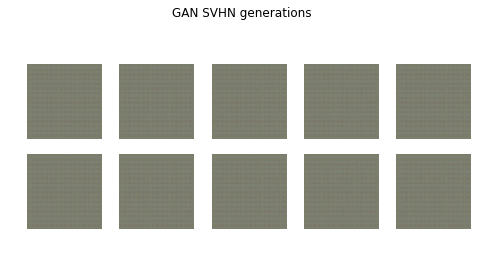

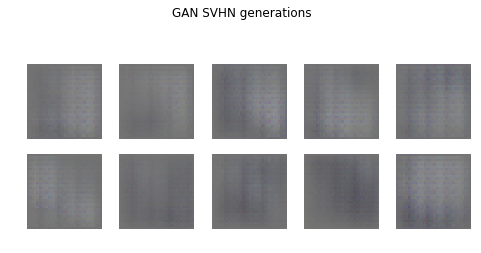

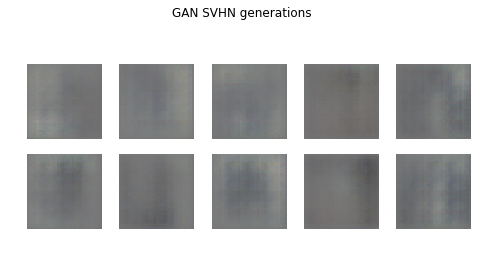

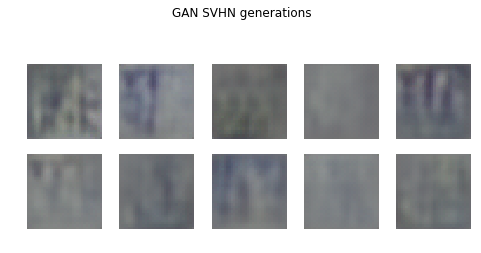

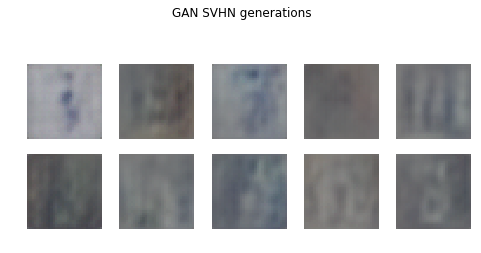

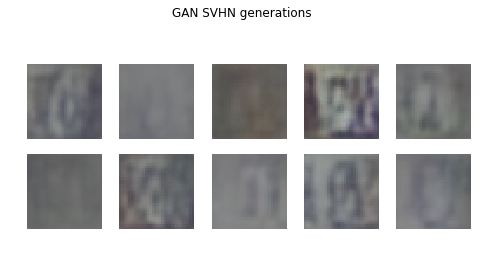

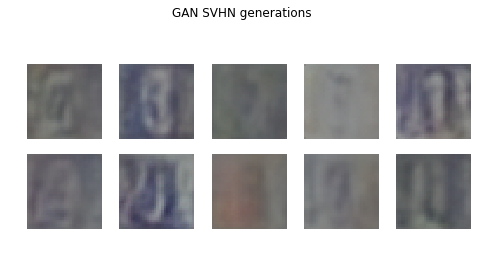

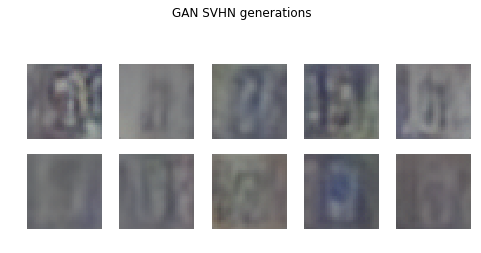

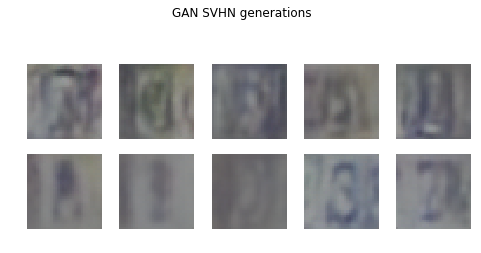

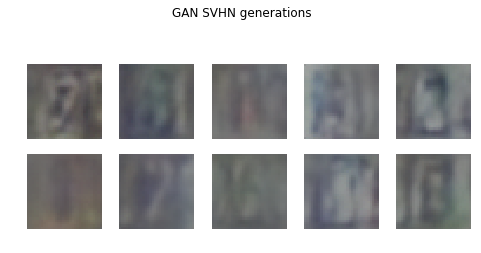

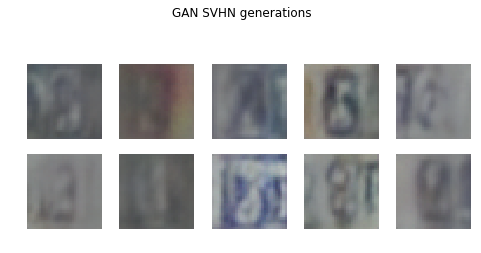

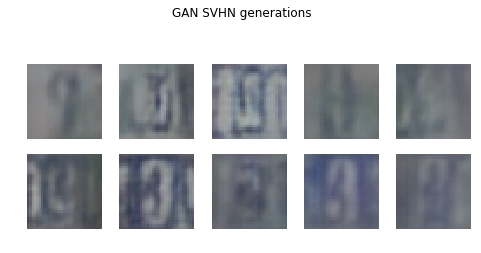

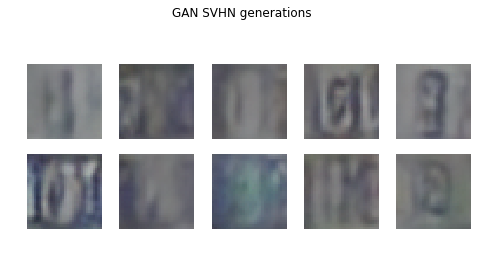

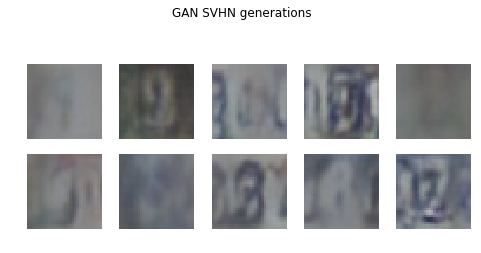

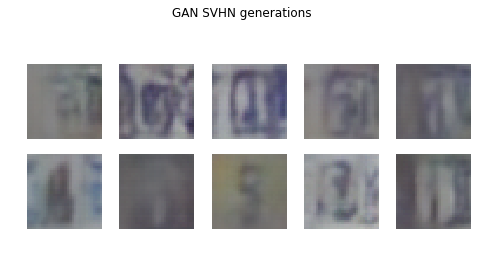

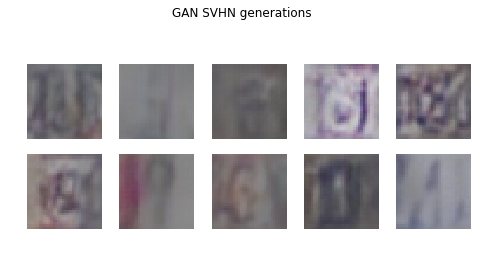

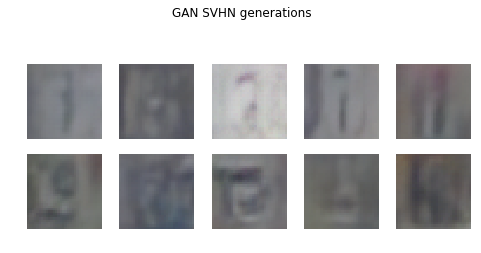

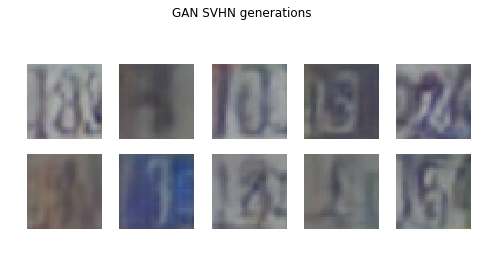

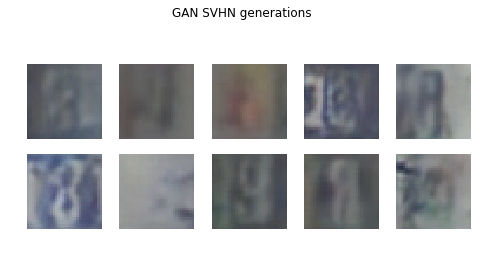

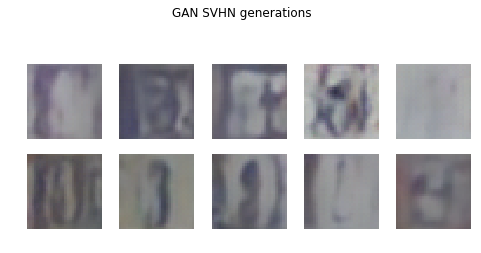

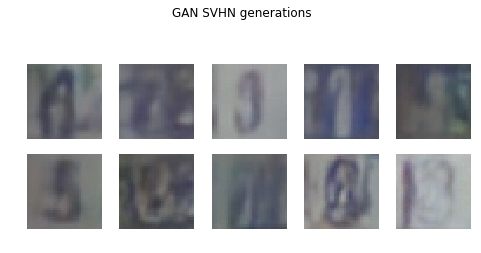

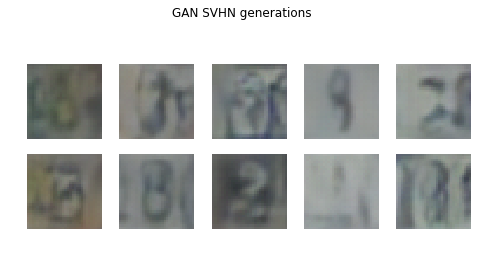

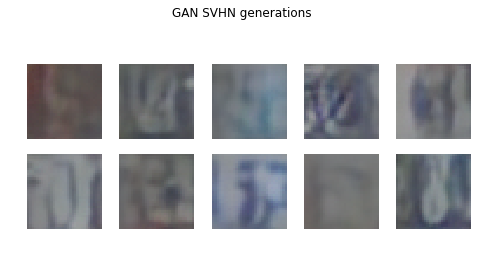

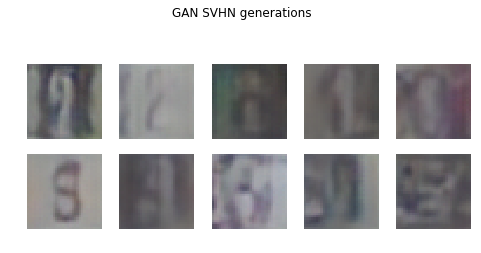

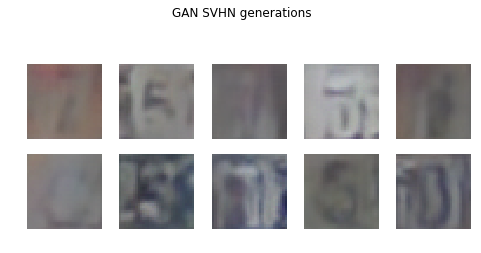

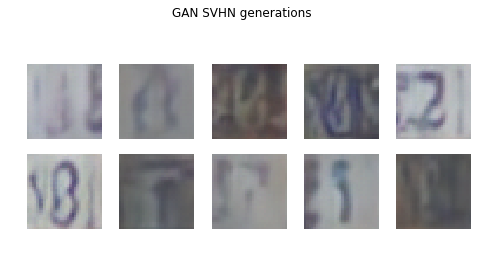

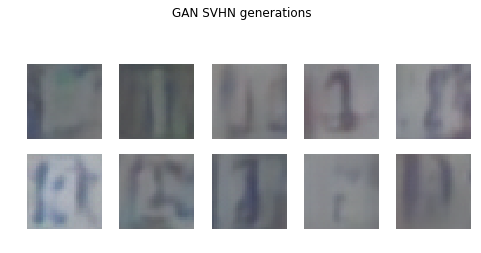

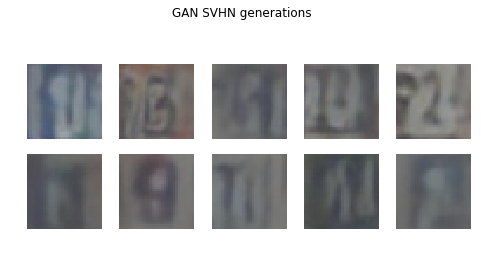

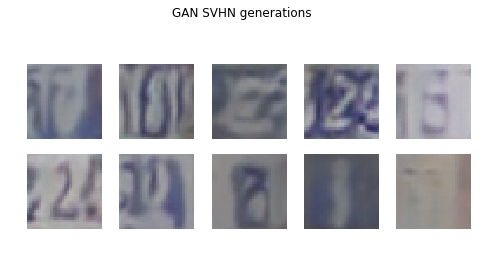

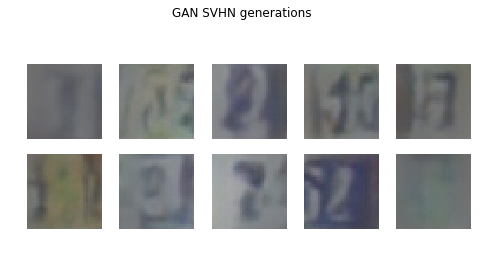

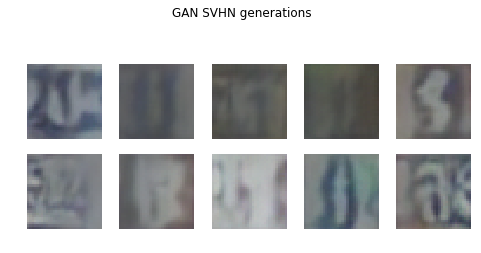

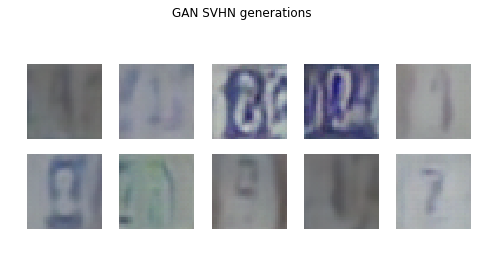

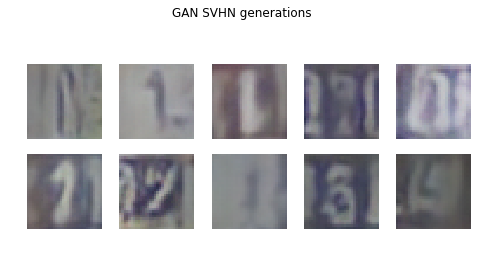

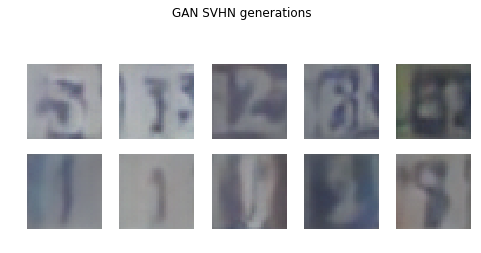

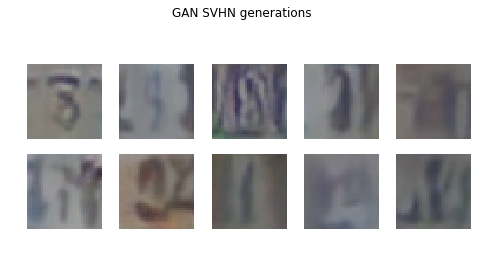

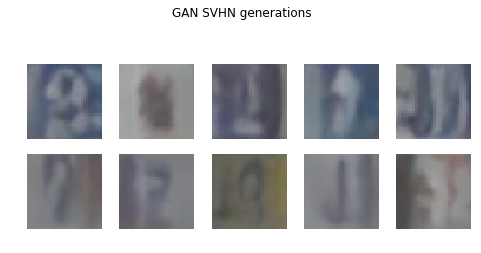

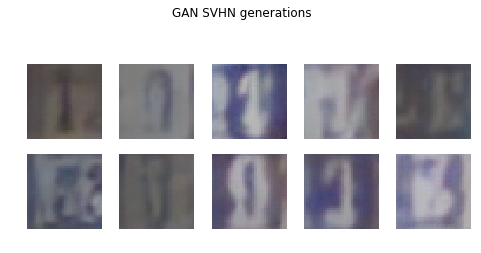

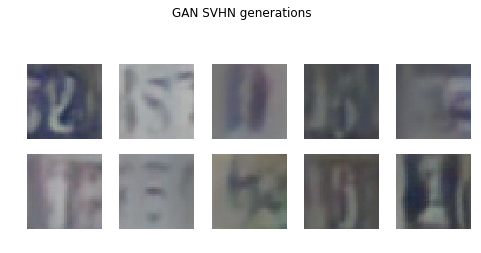

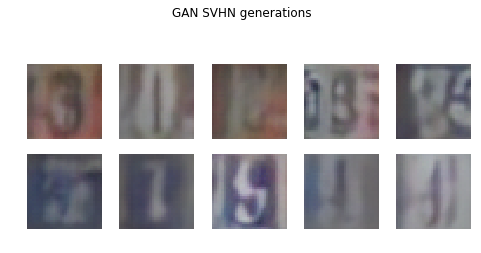

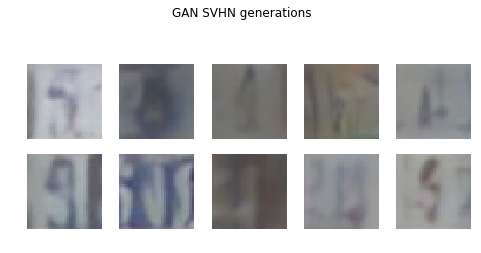

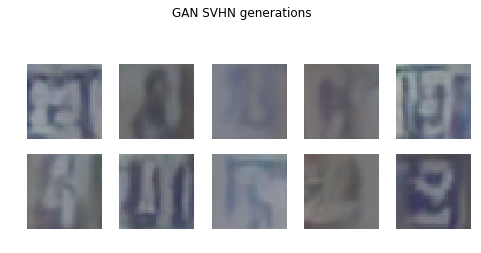

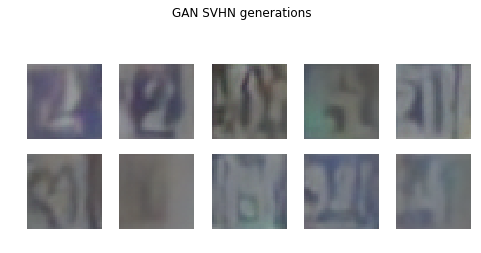

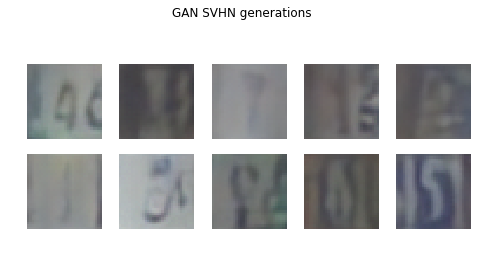

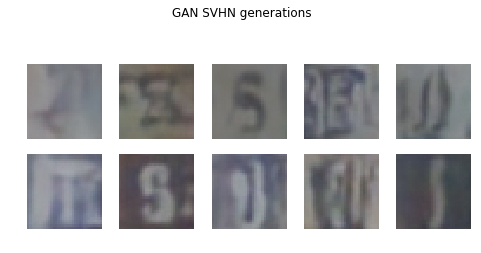

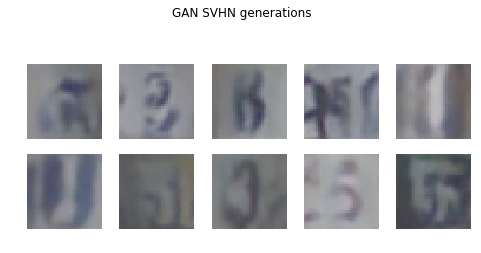

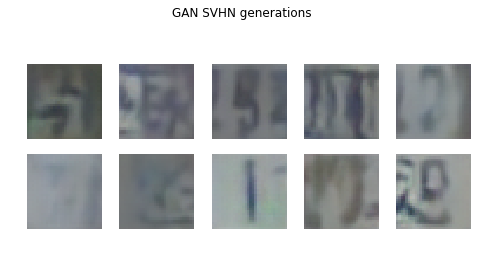

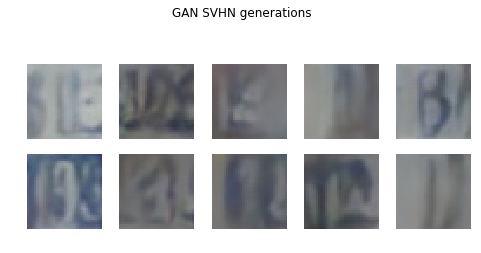

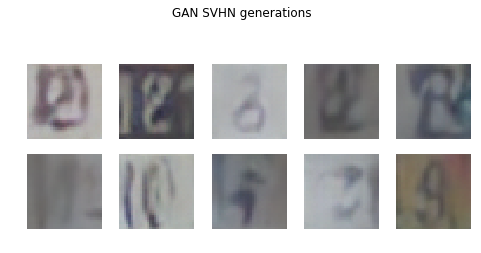

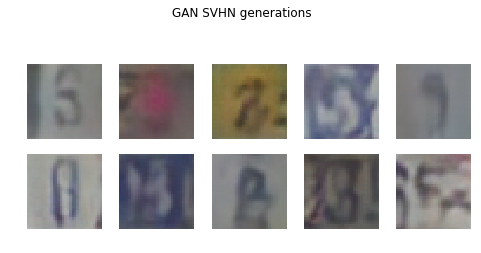

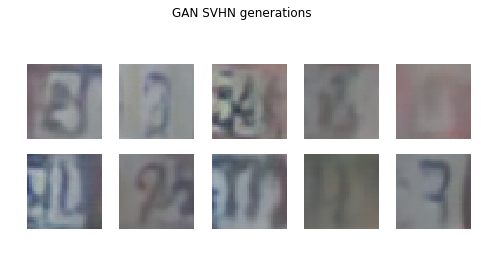

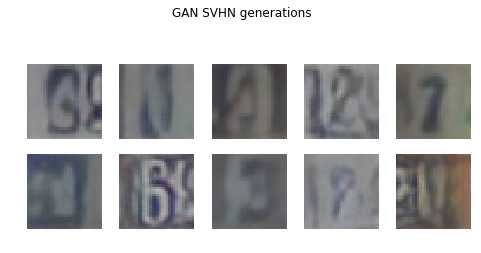

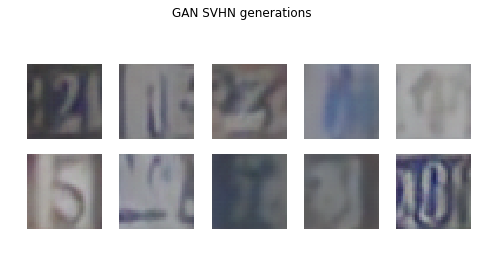

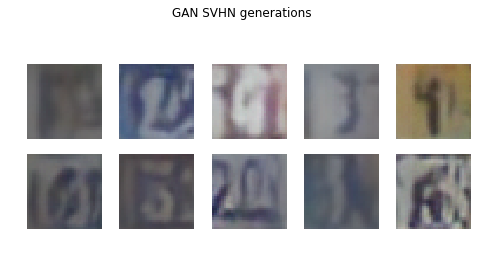

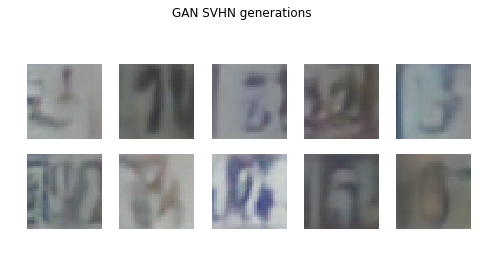

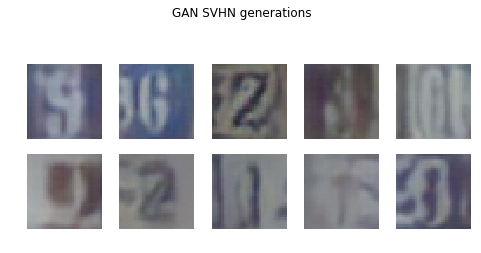

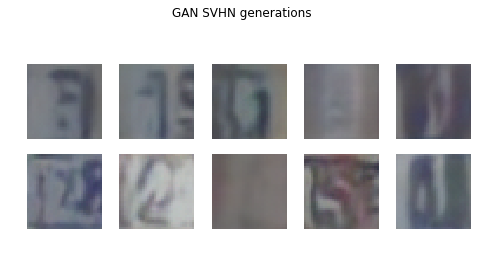

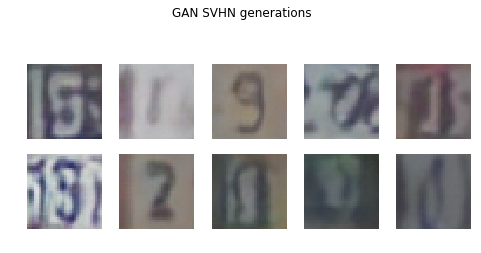

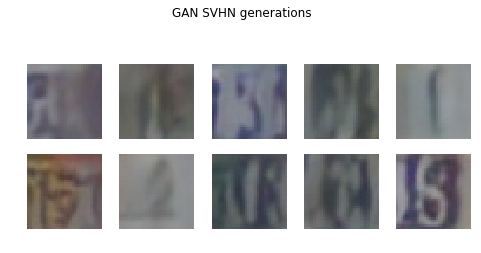

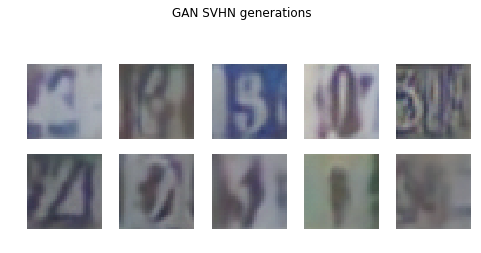

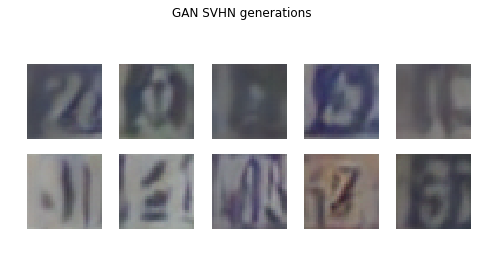

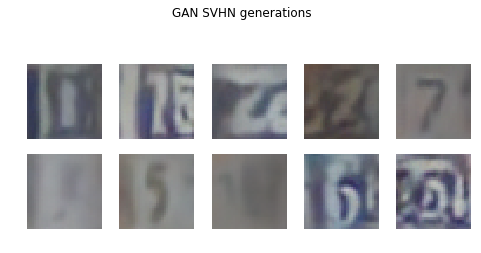

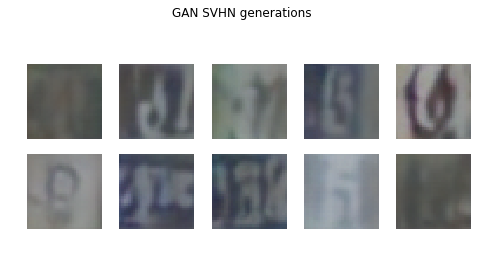

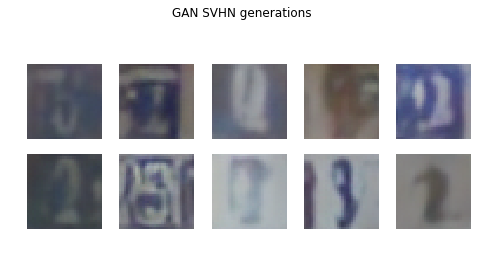

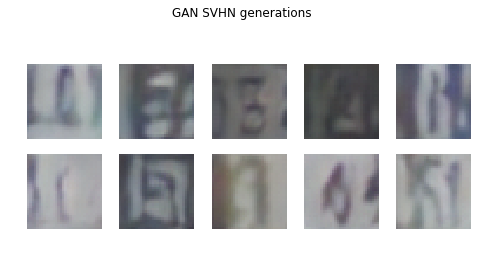

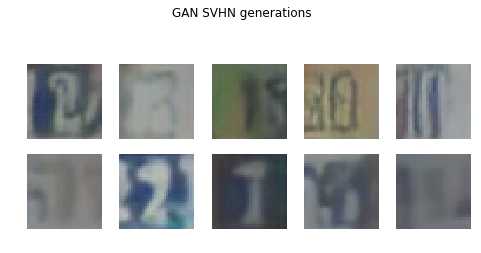

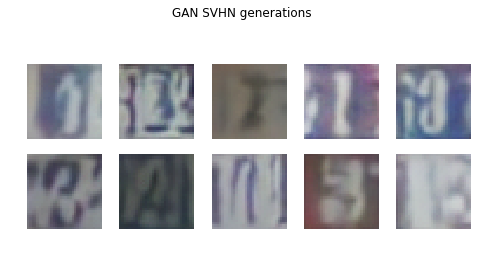

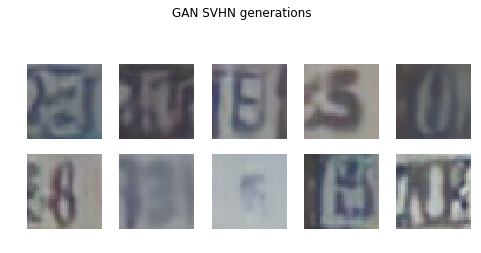

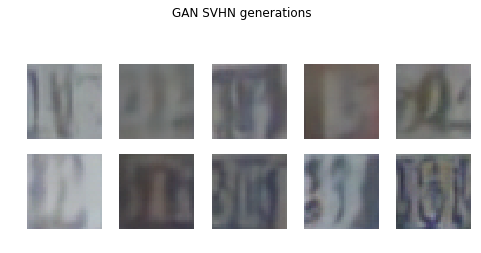

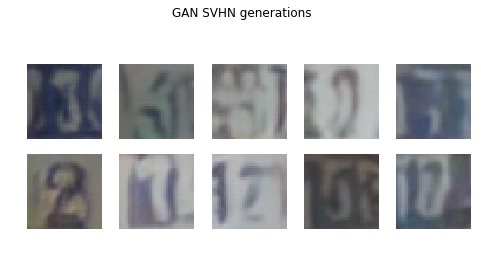

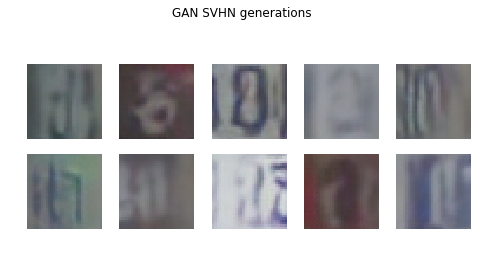

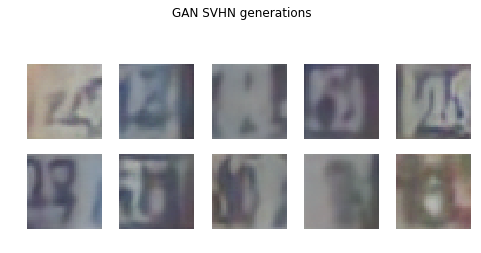

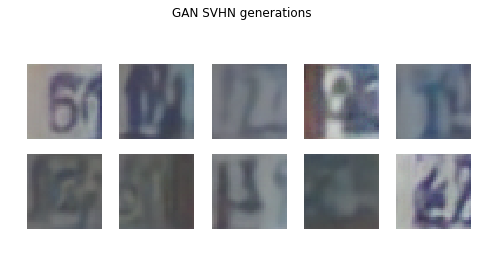

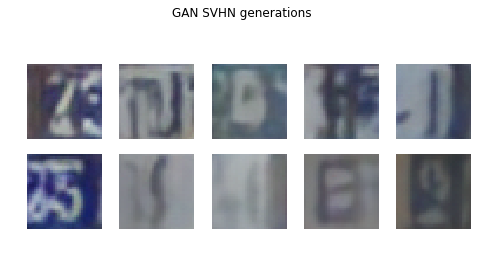

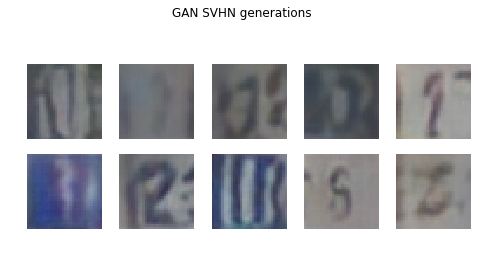

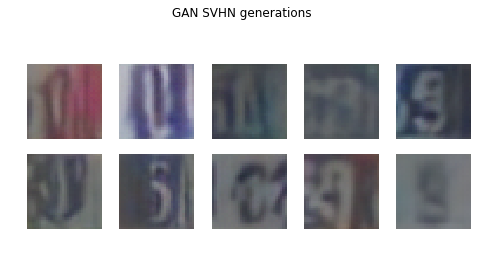

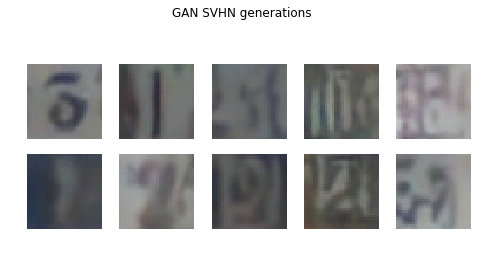

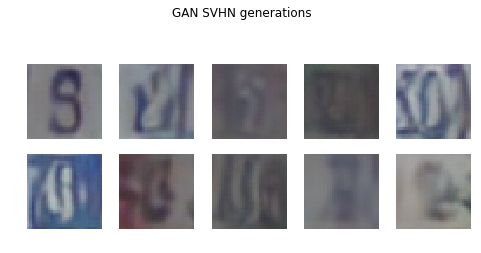

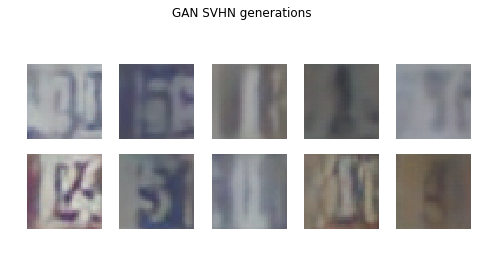

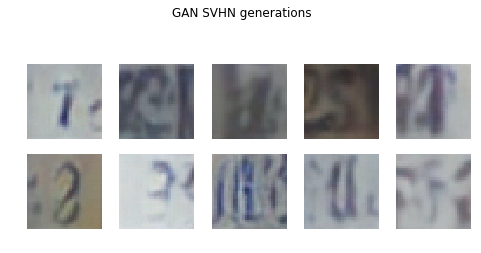

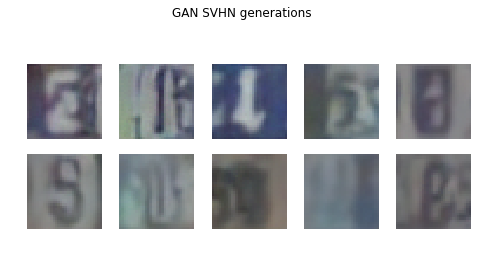

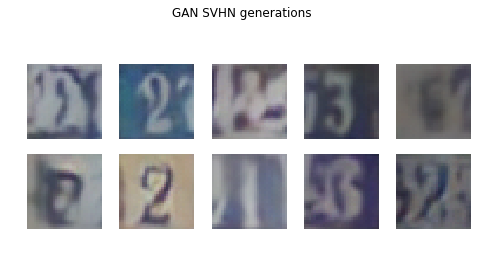

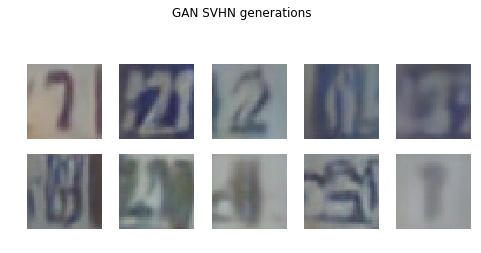

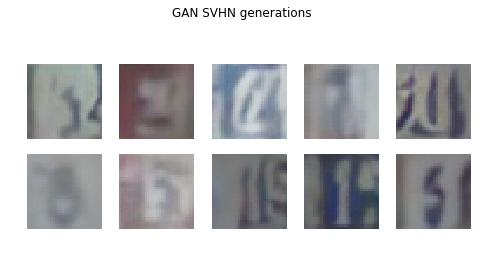

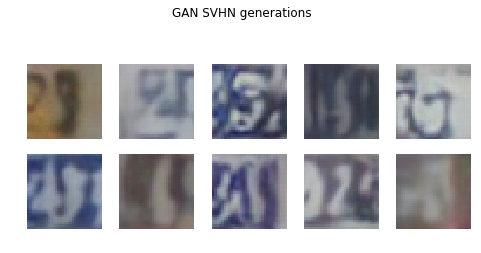

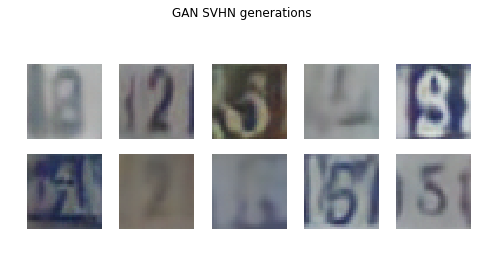

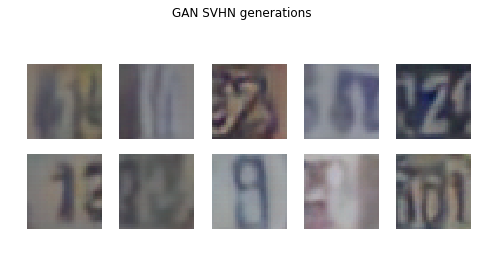

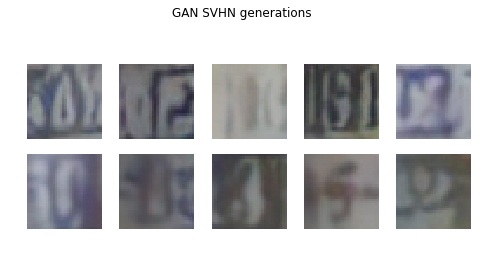

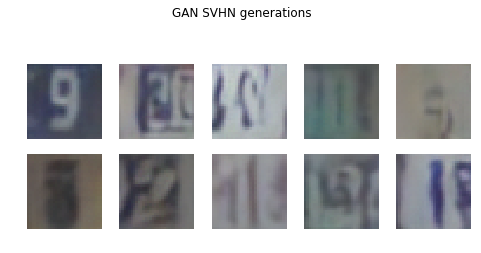

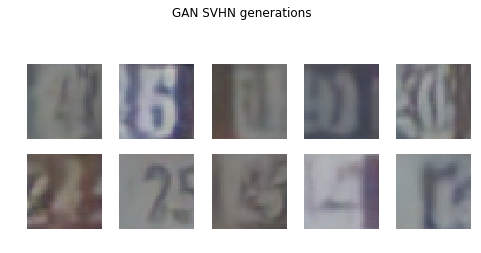

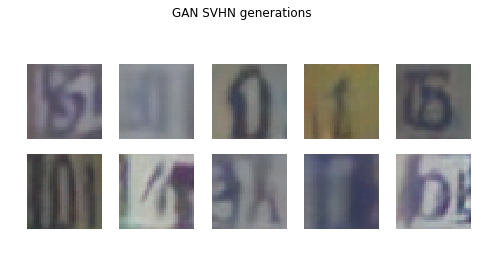

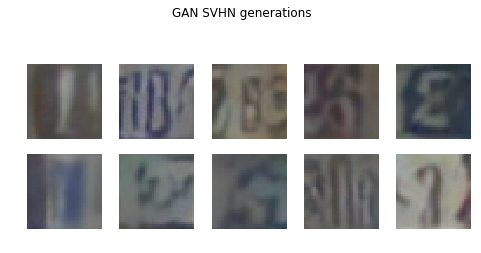

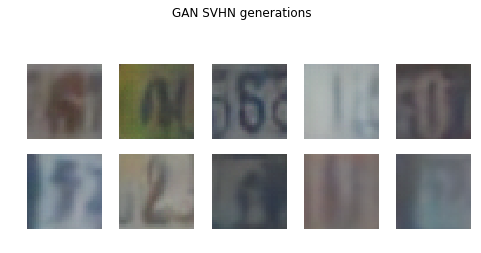

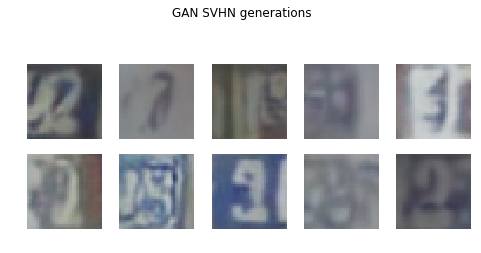

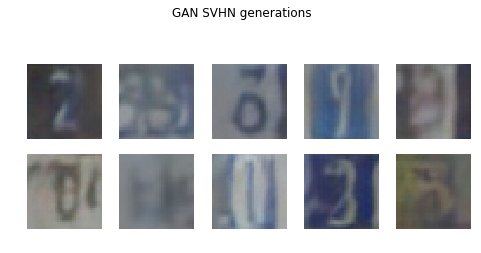

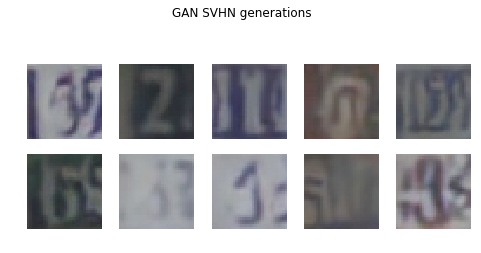

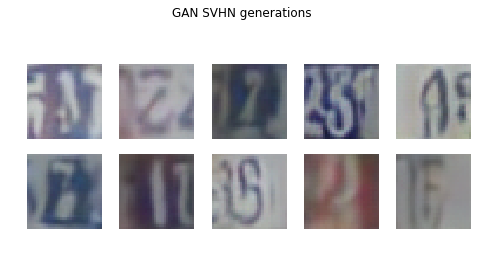

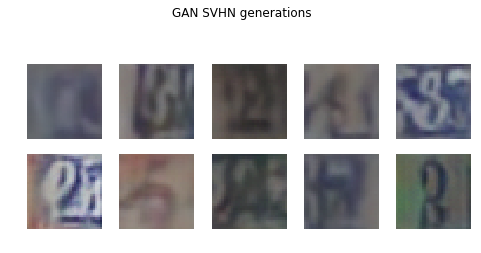

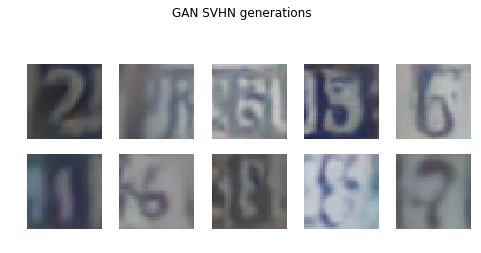

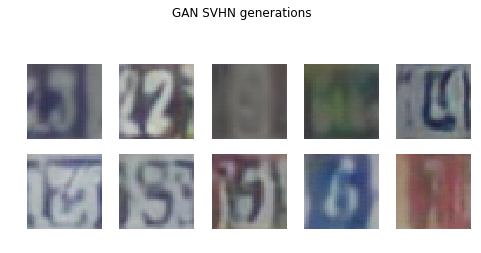

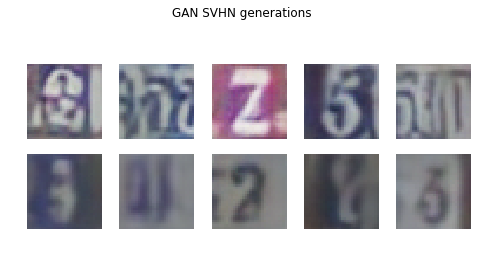

In [80]:
from utils.train_eval_utils_gan import train_model
print('~~~ Training with GPU ~~~') if use_cuda else print('~~~ Training with CPU ~~~\n')
num_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print('Generator has %.2fM trainable parameters.' % (num_params/1e6))
num_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Discriminator has %.2fM trainable parameters.\n' % (num_params/1e6))

optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
train_model(discriminator, generator, optimizer_d, optimizer_g,
            loader_train, loader_val, num_iterations, d_iterations, device, use_cuda, batch_size, scale)

In [81]:
PATH = 'generator%d.pt' % num_iterations
torch.save(generator, PATH)
PATH = 'discriminator%d.pt' % num_iterations
torch.save(discriminator, PATH)

# C. Qualitative Evaluation

## C.1. Generate Samples

In [82]:
num_generations = 64

### VAE

In [83]:
z = torch.randn(num_generations, num_latent).to(device)
model.eval()
with torch.no_grad():
    vae_generations = model.sample(z).cpu().numpy()
vae_generations = np.transpose(scale(vae_generations), (0, 2, 3, 1)).astype('uint8')

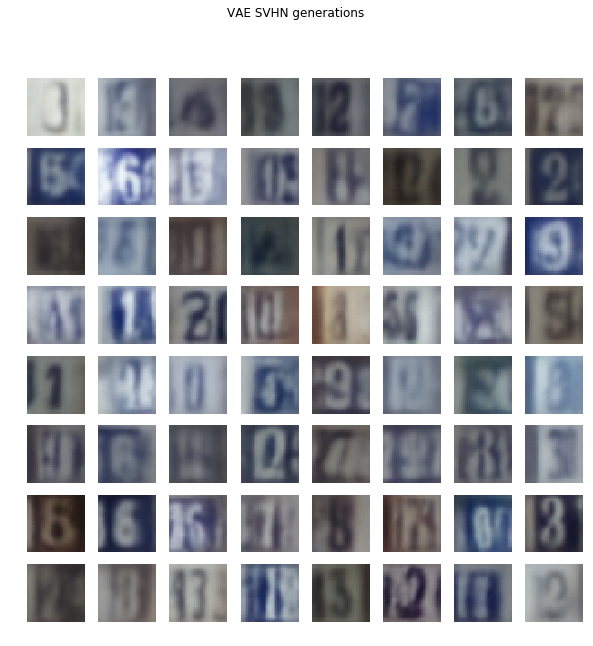

In [84]:
from utils.plotter import plot_and_save_images
plot_and_save_images(vae_generations, 'VAE')

### GAN

In [91]:
z = torch.randn(num_generations, num_latent).to(device)
generator.eval()
with torch.no_grad():
    gan_generations = generator.sample(z).cpu().numpy()
gan_generations = np.transpose(scale(gan_generations), (0, 2, 3, 1)).astype('uint8')

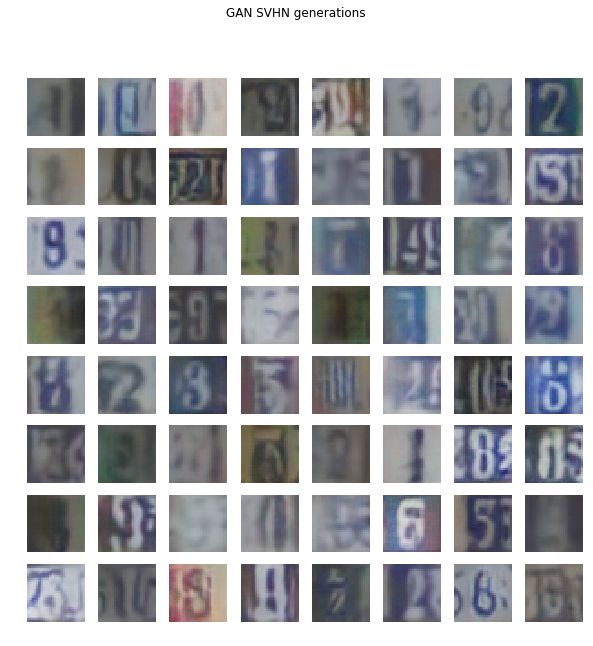

In [92]:
from utils.plotter import plot_and_save_images
plot_and_save_images(gan_generations, 'GAN')

## C.2. Disentanglement

### VAE

In [117]:
epsilon = 0.5
top_n = 15
num_interp = 9
z = torch.randn((1, num_latent)).to(device)

In [118]:
# Find dimensions that result in the most change:
vae_disentanglement = np.zeros((num_latent, 3, 32, 32))

model.eval()
with torch.no_grad():
    original = model.sample(z).cpu().numpy()
    for i in range(num_latent):
        z_ = z.clone().detach()
        z_[0, i] += epsilon
        vae_disentanglement[i] = model.sample(z_).cpu().numpy()

diff = np.sum((vae_disentanglement - original)**2, axis=(1,2,3))
topn_features = diff.argsort()[-top_n:][::-1]

print('Most effective latent dimensions:')
print(topn_features)

Most effective latent dimensions:
[41 50  9 19 40 90 69 51 23 72 80 95 83  5 66]


In [119]:
# Traverse along those dimensions:
vae_disentanglement = np.zeros((top_n, num_interp, 3, 32, 32))
with torch.no_grad():
    for i, feature in enumerate(topn_features):
        z_ = z.clone().detach()
        z_[0, feature] -= epsilon * np.floor(float(num_interp) / 2)
        for j in range(num_interp):
            if j != 0: z_[0, feature] += epsilon
            vae_disentanglement[i, j] = model.sample(z_).cpu().numpy()

vae_disentanglement = np.transpose(scale(vae_disentanglement), (0, 1, 3, 4, 2)).astype('uint8')

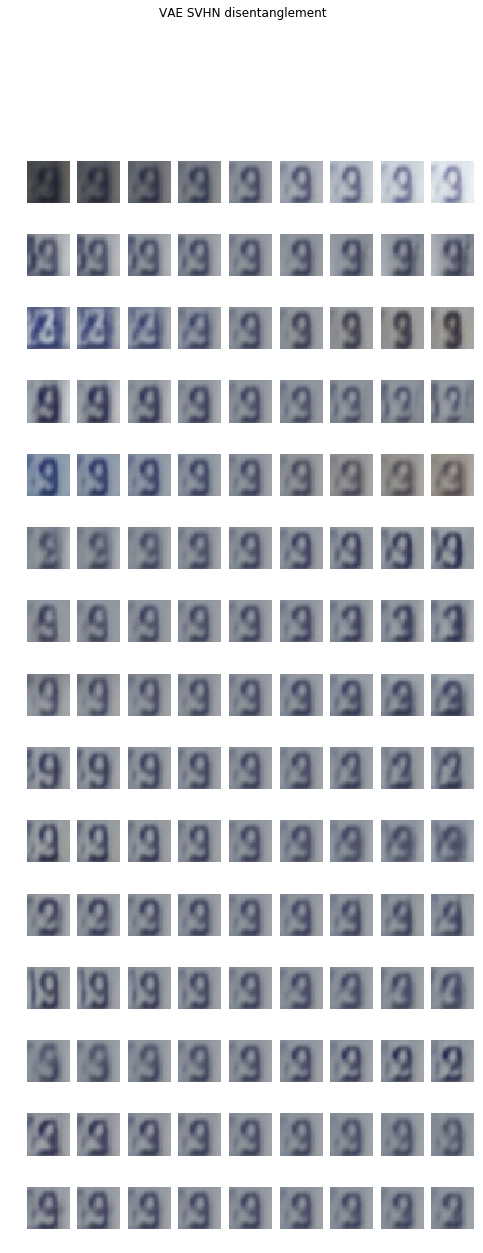

In [120]:
# Plot and save results
from utils.plotter import plot_and_save_disentanglement
plot_and_save_disentanglement(vae_disentanglement, num_rows=top_n, num_cols=num_interp, modelname='VAE')

### GAN

In [197]:
epsilon = 1.5
top_n = 15
num_interp = 9
z = torch.randn((1, num_latent)).to(device)

In [198]:
# Find dimensions that result in the most change:
gan_disentanglement = np.zeros((num_latent, 3, 32, 32))

generator.eval()
with torch.no_grad():
    original = generator.sample(z).cpu().numpy()
    for i in range(num_latent):
        z_ = z.clone().detach()
        z_[0, i] += epsilon
        gan_disentanglement[i] = generator.sample(z_).cpu().numpy()

diff = np.sum((gan_disentanglement - original)**2, axis=(1,2,3))
topn_features = diff.argsort()[-top_n:][::-1]

print('Most effective latent dimensions:')
print(topn_features)

Most effective latent dimensions:
[90 91 49 73 36 19 98 15  4 38 93 84 11  2 45]


In [199]:
# Traverse along those dimensions:
gan_disentanglement = np.zeros((top_n, num_interp, 3, 32, 32))
with torch.no_grad():
    for i, feature in enumerate(topn_features):
        z_ = z.clone().detach()
        z_[0, feature] -= epsilon * np.floor(float(num_interp) / 2)
        for j in range(num_interp):
            if j != 0: z_[0, feature] += epsilon
            gan_disentanglement[i, j] = generator.sample(z_).cpu().numpy()

gan_disentanglement = np.transpose(scale(gan_disentanglement), (0, 1, 3, 4, 2)).astype('uint8')

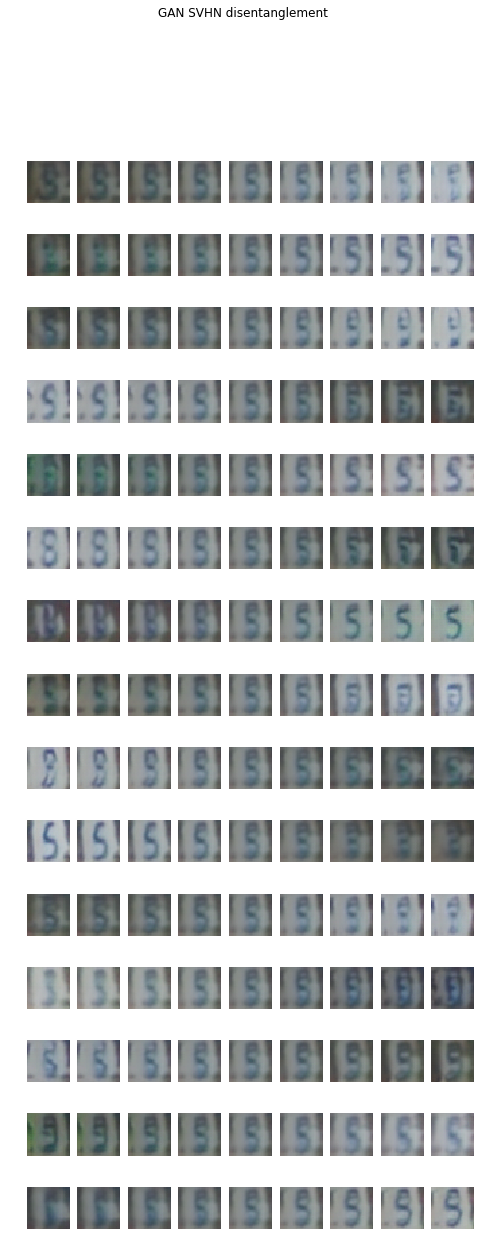

In [200]:
# Plot and save results
from utils.plotter import plot_and_save_disentanglement
plot_and_save_disentanglement(gan_disentanglement, num_rows=top_n, num_cols=num_interp, modelname='GAN')

## C.3. Interpolation

### VAE latent

In [222]:
num_interp = 11

z0 = torch.randn((1, num_latent)).to(device)
z1 = torch.randn((1, num_latent)).to(device)

In [223]:
scales = np.linspace(0, 1, num_interp)
vae_latent = np.zeros((num_interp, 3, 32, 32))
with torch.no_grad():
    for i, s in enumerate(scales):
        z = (s * z0) + ((1 - s) * z1)
        vae_latent[i] = model.sample(z).cpu().numpy()

vae_latent = np.transpose(scale(vae_latent), (0, 2, 3, 1)).astype('uint8')

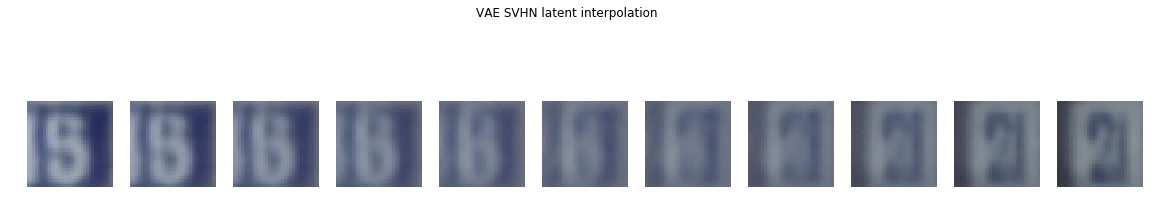

In [224]:
from utils.plotter import plot_and_save_interpolation
plot_and_save_interpolation(vae_latent, num_cols=num_interp, spacename='latent', modelname='VAE')

### VAE data

In [225]:
scales = np.linspace(0, 1, num_interp)
vae_data = np.zeros((num_interp, 3, 32, 32))
with torch.no_grad():
    data0 = model.sample(z0).cpu().numpy()
    data1 = model.sample(z1).cpu().numpy()

for i, s in enumerate(scales):
    data = (s * data0) + ((1 - s) * data1)
    vae_data[i] = data

vae_data = np.transpose(scale(vae_data), (0, 2, 3, 1)).astype('uint8')

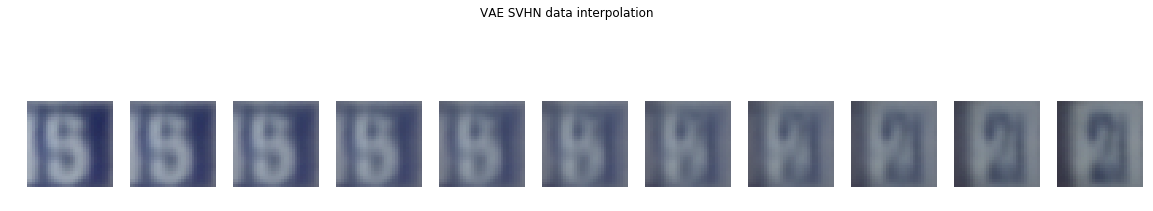

In [226]:
plot_and_save_interpolation(vae_data, num_cols=num_interp, spacename='data', modelname='VAE')

### GAN latent

In [281]:
z0 = torch.randn((1, num_latent)).to(device)
z1 = torch.randn((1, num_latent)).to(device)

In [282]:
scales = np.linspace(0, 1, num_interp)
gan_latent = np.zeros((num_interp, 3, 32, 32))
with torch.no_grad():
    for i, s in enumerate(scales):
        z = (s * z0) + ((1 - s) * z1)
        gan_latent[i] = generator.sample(z).cpu().numpy()

gan_latent = np.transpose(scale(gan_latent), (0, 2, 3, 1)).astype('uint8')

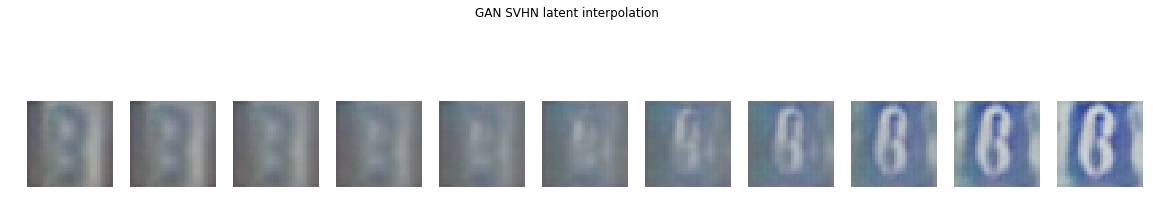

In [283]:
from utils.plotter import plot_and_save_interpolation
plot_and_save_interpolation(gan_latent, num_cols=11, spacename='latent', modelname='GAN')

### GAN data

In [284]:
scales = np.linspace(0, 1, num_interp)
gan_data = np.zeros((num_interp, 3, 32, 32))
with torch.no_grad():
    data0 = generator.sample(z0).cpu().numpy()
    data1 = generator.sample(z1).cpu().numpy()

for i, s in enumerate(scales):
    data = (s * data0) + ((1 - s) * data1)
    gan_data[i] = data

gan_data = np.transpose(scale(gan_data), (0, 2, 3, 1)).astype('uint8')

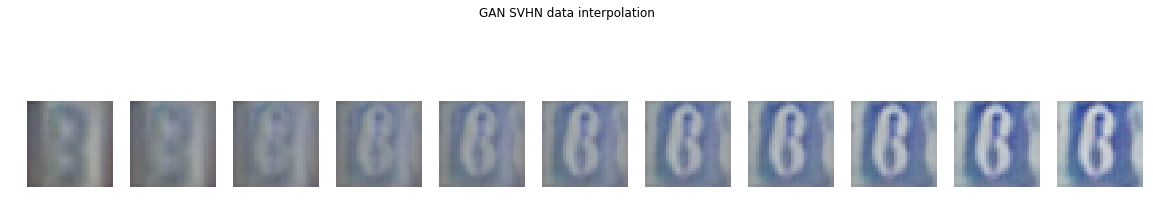

In [285]:
plot_and_save_interpolation(gan_data, num_cols=num_interp, spacename='data', modelname='GAN')

# D. Quantitative Evaluations

In [286]:
num_generations = 1000

### VAE Generate & Store Samples

In [287]:
z = torch.randn(num_generations, num_latent).to(device)
model.eval()
with torch.no_grad():
    vae_generations = model.sample(z).cpu().numpy()
vae_generations = np.transpose(scale(vae_generations), (0, 2, 3, 1)).astype('uint8')

In [288]:
from utils.plotter import sample_saver
sample_saver(vae_generations, path='samples\\VAE\\subfolder')

### VAE FID score

In [289]:
! python score_fid.py --model=svhn_classifier.pt samples\VAE

Test
Using downloaded and verified file: Dataset\SVHN\test_32x32.mat
FID score: 34702.24130179765


### GAN Generate & Store Samples

In [290]:
z = torch.randn(num_generations, num_latent).to(device)
generator.eval()
with torch.no_grad():
    gan_generations = generator.sample(z).cpu().numpy()
gan_generations = np.transpose(scale(gan_generations), (0, 2, 3, 1)).astype('uint8')

In [291]:
from utils.plotter import sample_saver
sample_saver(gan_generations, path='samples\\GAN\\subfolder')

### GAN FID score

In [292]:
! python score_fid.py --model=svhn_classifier.pt samples\GAN

Test
Using downloaded and verified file: Dataset\SVHN\test_32x32.mat
FID score: 31714.731880772186
